In [240]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import random
import time

random_seed = 7
n = 100
sigmas = [0.0001, 0.001, 0.01, 0.1]
K = 1500 #number of iterations, if you want faster compilation reduce to 1500

random.seed(random_seed)
np.random.seed(random_seed)

In [241]:
def generate_synthetic_data(n, sigma):
    C = 0.01 * np.random.randn(n, n) + np.eye(n)
    D = np.diag(np.random.uniform(0, 1, n))
    A = np.dot(C, np.dot(D, C.T)) + sigma * np.eye(n)  # A = CDC^T + sigma*I
    b = np.random.uniform(0, 1, n)
    return A, b

def least_squares_function(x, A, b):
    return 0.5 * np.linalg.norm(np.dot(A, x) - b)**2

datasets = []
for sigma in sigmas:
    A, b = generate_synthetic_data(n, sigma)
    datasets.append((A, b, sigma))

A, b, sigma = datasets[1]

ATA = np.dot(A.T, A)
L = np.linalg.eigvalsh(ATA).max()
mu = np.linalg.eigvalsh(ATA).min()
kappa = L / mu

learning_rate_gd = 2 / (L + mu)
x_star = np.linalg.solve(ATA, np.dot(A.T, b))
f_star = least_squares_function(x_star, A, b)

x_init = np.random.randn(n)
x_init = x_init / np.linalg.norm(x_init)

P_i = np.zeros((n, n))
print(f"L: {L}, mu: {mu}, kappa: {kappa}, step size: {learning_rate_gd}, f(x*): {f_star}")

L: 1.0514728867180296, mu: 0.00010288008666103869, kappa: 10220.373260204773, step size: 1.9019076543359148, f(x*): 5.853324805580575e-29


In [242]:
def gd(f, grad_f, x_init, num_iterations, L, f_star, tol=1e-10):
    x = x_init
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        if np.linalg.norm(grad) <= tol:
          print(f"GD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
          break
        x = x - 1/L * grad

        gap_history.append(f(x) - f_star)

    return gap_history

In [243]:
def AOR_HB(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10, eta_P=0.001, eta_beta=0.002, P_init=None, beta_init=None):

    x = x_init.copy()
    x_prev = x_init.copy()
    n = len(x_init)

    if P_init is None:
        denom = (np.sqrt(L) + np.sqrt(mu))**2
        P = np.eye(n) * (1 / denom)
    else:
        P = P_init.copy()

    if beta_init is None:
        denom = (np.sqrt(L) + np.sqrt(mu))**2
        beta = L / denom
    else:
        beta = beta_init

    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_prev = grad_f(x_prev)

        if np.linalg.norm(grad) <= tol:
            print(f"AOR_HB converged at iteration {k}")
            break

        x_next = x - P @ (2*grad - grad_prev) + beta * (x - x_prev)

        grad_term = -(2*grad - grad_prev)
        dP = np.outer(grad_term, grad_f(x_next))

        momentum_term = (x - x_prev)
        dbeta = np.dot(momentum_term, grad_f(x_next))

        P = P - eta_P * dP
        beta = beta - eta_beta * dbeta

        x_prev = x
        x = x_next
        gap_history.append(f(x) - f_star)

    return gap_history

In [244]:
def agd(f, grad_f, x_init, num_iterations, L, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        a = 0.5 * (1 + np.sqrt(1 + 4 * A))
        A_next = A + a

        y = x + (1 - A / A_next) * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e10, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"AGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = z - ((A_next - A) / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [245]:
def solve_quadratic(A_k, q):
    a = 1 - q
    b = -2 * A_k - 1
    c = A_k**2
    roots = np.roots([a, b, c])
    A_next = roots[np.isreal(roots) & (roots > 0)].real[0]
    return A_next

def sagd(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10):
    x = x_init
    z = x_init
    A = 0
    q = mu / L
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        A_next = solve_quadratic(A, q)

        tau_k = (A_next - A) * (1 + q * A) / (A_next + 2 * q * A * A_next - q * A**2)
        delta_k = (A_next - A) / (1 + q * A_next)

        y = x + tau_k * (z - x)

        grad = grad_f(y)
        grad = np.clip(grad, -1e6, 1e6)

        if np.linalg.norm(grad) <= tol:
            print(f"SAGD converged at iteration {k} with gradient norm {np.linalg.norm(grad):.2e}")
            break

        x_next = y - (1 / L) * grad
        z_next = (1 - q * delta_k) * z + q * delta_k * y - (delta_k / L) * grad

        x, z, A = x_next, z_next, A_next

        gap_history.append(f(x) - f_star)

    return gap_history

In [246]:
def adagrad(f, grad_f, x_init, num_iterations, f_star, epsilon=1e-8, alpha=1.0, tol=1e-10):
    x = x_init.copy()
    g_accum = np.zeros_like(x)
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        if np.linalg.norm(grad) <= tol:
            print(f"AdaGrad converged at iteration {k}")
            break

        g_accum += grad ** 2
        adjusted_grad = grad / (np.sqrt(g_accum) + epsilon)
        x = x - alpha * adjusted_grad
        gap_history.append(f(x) - f_star)

    return gap_history

In [247]:
def calculate_effective_kappa(A, P):
    ATA = A.T @ A

    if P.ndim == 2:
        p_diag = np.diag(P)
    else:
        p_diag = P.copy()

    if np.any(p_diag <= 0):
        print(f"Warning: non-positive diagonal elements in P: min={np.min(p_diag)}")
        return float('inf')

    p_sqrt = np.sqrt(p_diag)

    AP_sqrt = A * p_sqrt
    M = AP_sqrt.T @ AP_sqrt

    eig_vals = np.linalg.eigvalsh(M)

    eig_vals = eig_vals[eig_vals > 1e-12]

    if len(eig_vals) < 2:
        return float('inf')

    L_kappa = eig_vals.max()
    mu_kappa = eig_vals.min()
    kappa_star = L_kappa / mu_kappa

    return kappa_star

In [248]:
def osgm_r(f, grad_f, P_init, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = P_init
    history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)
        f_gap = f(x) - f_star

        if grad_norm <= tol or f_gap <= tol:
            print(f"OSGM-R converged at iteration {k} with gradient norm {grad_norm:.2e} and function gap {f_gap:.2e}")
            break

        x_next = x - P @ grad

        grad_next = grad_f(x_next)
        surrogate_grad = - (grad * grad_next) / max(f_gap, tol)
        P = P - eta * np.diag(surrogate_grad)
        x = x_next
        history.append(f(x) - f_star)
    kappa = calculate_effective_kappa(A, P)
    print(kappa)
    return history

In [249]:
def hessian_vector_product(A, v):
    return A.T @ (A @ v)

def osgm_g(f, grad_f, A, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = np.diag(P_ini.copy())
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm <= tol:
            print(f"OSGM-G converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break
        x_plus = x - P @ grad

        grad_plus = grad_f(x_plus)
        grad_plus_norm = np.linalg.norm(grad_plus)

        hess_vec = hessian_vector_product(A, grad_plus)

        numerator = np.outer(hess_vec, grad)

        denominator = grad_norm * grad_plus_norm

        if np.isnan(denominator) or denominator < 1e-12:
            x = x_plus
            gap_history.append(f(x) - f_star)
            continue
        surrogate_grad = -numerator / (denominator + 1e-12)

        surrogate_grad = np.clip(surrogate_grad, -1e3, 1e3)
        P = P - eta * surrogate_grad

        P = np.diag(np.diag(P))
        P = np.clip(P, -10, 10)

        if np.any(np.isnan(surrogate_grad)) or np.any(np.isnan(P)):
            break

        x = x_plus
        gap_history.append(f(x) - f_star)

        if grad_norm > 1e8:
            break
    kappa = calculate_effective_kappa(A, P)
    print(kappa)
    return gap_history

In [250]:
def osgm_h(f, grad_f, P_ini, x_init, num_iter, eta, f_star, tol=1e-10):
  x = x_init
  P = P_ini
  gap_history = [f(x) - f_star]

  for k in range(num_iter):
    grad = grad_f(x)
    grad_norm = np.linalg.norm(grad)

    if grad_norm <= tol:
            print(f"OSGM-H converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

    x_next = x - P@grad

    if f(x_next) > f(x):
      x_next = x

    h_x_P = (f(x_next) -  f(x))/(grad_norm**2)
    surrogate_grad = -np.outer(grad_f(x_next), grad)/(grad_norm**2)
    P = P - eta*surrogate_grad
    x = x_next

    gap_history.append(f(x) - f_star)
  kappa_star = calculate_effective_kappa(A, P)
  print(kappa_star)
  return gap_history

In [251]:
def g(f, grad_f, x, x_prev, P, mu, f_star, tol):
    x_perturbed = x + mu * (x - x_prev)
    grad_perturbed = grad_f(x_perturbed)
    term = x_perturbed - P * grad_perturbed
    numerator = f(term) - f_star
    denominator = f(x) - f_star
    return numerator / max(denominator, tol)

def osgm_r_accelerated(A, b, f, grad_f, P_init, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init.copy()
    x_prev = x_init.copy()
    mu = 0.0
    P = np.diag(P_init).copy()
    history = [f(x) - f_star]

    grad_g_wrt_x = grad(g, argnum=2)
    grad_g_wrt_P = grad(g, argnum=4)
    grad_g_wrt_mu = grad(g, argnum=5)

    for k in range(num_iterations):
        grad_current = grad_f(x + mu*(x - x_prev))
        grad_norm = np.linalg.norm(grad_current)
        f_gap = f(x) - f_star

        if grad_norm <= tol or f_gap <= tol:
            print(f"OSGM_R_Accelerated converged at iteration {k} with grad_norm={grad_norm:.2e} and f_gap={f_gap:.2e}")
            break

        dg_dx = grad_g_wrt_x(f, grad_f, x, x_prev, P, mu, f_star, tol)
        dg_dP = grad_g_wrt_P(f, grad_f, x, x_prev, P, mu, f_star, tol)
        dg_dmu = grad_g_wrt_mu(f, grad_f, x, x_prev, P, mu, f_star, tol)

        x_next = x + mu*(x - x_prev) - P * (A @ x + mu * A @ (x - x_prev) -  b)

        P_next = P - eta * np.clip(dg_dP, -1e-2, 1e-2)
        mu_next = mu - eta * np.clip(dg_dmu, -1e-2, 1e-2)

        x_prev, x, P, mu = x, x_next, P_next, mu_next
        history.append(f(x) - f_star)
    return history

In [252]:
def run_basic_optimizer(optimizer_func, f, grad_f, x_init, num_iterations, f_star, **extra_params):
    gap_history = optimizer_func(f, grad_f, x_init, num_iterations, f_star=f_star, **extra_params)
    if gap_history and gap_history[0] != 0:
        return [g / gap_history[0] for g in gap_history]
    return gap_history

In [253]:
def run_osgm_methods(eta_list, f, grad_f, P_init, x_init, num_iterations, f_star, method, A=None, b=None):
    results = []
    for eta in eta_list:
        if method == 'osgm_r':
            gap_history = osgm_r(f, grad_f, P_init, x_init, num_iterations, eta, f_star)
        elif method == 'osgm_g':
            gap_history = osgm_g(f, grad_f, A, P_init, x_init, num_iterations, eta, f_star)
        elif method == 'osgm_h':
            gap_history = osgm_h(f, grad_f, P_init, x_init, num_iterations, eta, f_star)
        elif method == 'osgm_r_accelerated':
            gap_history = osgm_r_accelerated(A, b, f, grad_f, P_init, x_init, num_iterations, eta, f_star)

        if gap_history and gap_history[0] != 0:
            gap_history = [g / gap_history[0] for g in gap_history]
        results.append(gap_history)

    return results

In [254]:
def AOR_HB_autograd(f, grad_f, x_init, num_iterations, L, mu, f_star, tol=1e-10, eta_P=0.001, eta_beta=0.002):
    x = x_init.copy()
    x_prev = x_init.copy()

    denom = (np.sqrt(L) + np.sqrt(mu))**2
    P = np.eye(len(x_init)) * (1 / denom)
    beta = L / denom

    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad_current = grad_f(x)
        grad_prev = grad_f(x_prev)

        if np.linalg.norm(grad_current) <= tol:
            print(f"AOR_HB_autograd converged at iteration {k}")
            break

        def meta_loss_P(P_vec):
            P_mat = P_vec.reshape(P.shape)
            x_test = x - P_mat @ (2*grad_current - grad_prev) + beta * (x - x_prev)
            return f(x_test)

        def meta_loss_beta(beta_val):
            x_test = x - P @ (2*grad_current - grad_prev) + beta_val * (x - x_prev)
            return f(x_test)

        dP_flat = grad(meta_loss_P)(P.flatten())
        dbeta = grad(meta_loss_beta)(beta)

        dP = dP_flat.reshape(P.shape)

        P = P - eta_P * dP
        beta = beta - eta_beta * dbeta

        x_next = x - P @ (2*grad_current - grad_prev) + beta * (x - x_prev)

        x_prev, x = x, x_next
        gap_history.append(f(x) - f_star)

    return gap_history

In [255]:
def run_AOR_HB_methods(eta_P_list, eta_beta_list, f, grad_f, x_init, num_iterations, L, mu, f_star, P_init=None, beta_init=None):
    results = []

    for eta_P in eta_P_list:
        for eta_beta in eta_beta_list:
            gap_history = AOR_HB(
                f, grad_f, x_init, num_iterations, L, mu, f_star,
                eta_P=eta_P, eta_beta=eta_beta, P_init=P_init, beta_init=beta_init
            )
            if gap_history and gap_history[0] != 0:
                gap_history = [g / gap_history[0] for g in gap_history]
            results.append((gap_history, eta_P, eta_beta))

    return results

In [256]:
def run_AOR_HB_methods_autograd(eta_P_list, eta_beta_list, f, grad_f, x_init, num_iterations, L, mu, f_star):
    results = []

    for eta_P in eta_P_list:
        for eta_beta in eta_beta_list:
            gap_history = AOR_HB_autograd(
                f, grad_f, x_init, num_iterations, L, mu, f_star,
                eta_P=eta_P, eta_beta=eta_beta
            )
            if gap_history and gap_history[0] != 0:
                gap_history = [g / gap_history[0] for g in gap_history]
            results.append((gap_history, eta_P, eta_beta))

    return results

In [257]:
def plot_convergence_smart(histories_with_info, sigma, max_display_iter=10000, tol=1e-10, min_display_value=1e-16):

    plt.figure(figsize=(10, 5))

    for history, label, eta in histories_with_info:
        if not history or np.any(np.isnan(history)):
            continue

        display_point = find_display_point(history, tol, min_display_value)
        display_iter = min(display_point + 50, len(history), max_display_iter)

        display_history = history[:display_iter]

        full_label = f"{label} (η={eta})" if eta is not None else label

        plt.plot(range(len(display_history)), display_history,
                label=full_label, linewidth=2.5, alpha=0.9)

    plt.title(f'Convergence Comparison: Function Value Gap, sigma: {sigma}', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Normalized Function Value Gap', fontsize=12)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.minorticks_on()

    plt.yscale('log')
    plt.ylim(bottom=min_display_value)

    plt.legend(fontsize=10, framealpha=0.9, edgecolor='black')

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.gca().yaxis.set_major_locator(plt.LogLocator(numticks=15))

    plt.tight_layout()
    plt.show()

def find_display_point(history, tol=1e-10, min_display_value=1e-16):
    if len(history) < 2:
        return len(history)
    for i, value in enumerate(history):
        if value < tol and value > min_display_value:
            return i

    min_value = min(history)
    min_indices = [i for i, val in enumerate(history) if val == min_value]

    if min_indices:
        return min(min_indices)
    else:
        return len(history)

In [258]:
def plot_eta_convergence_analysis(method_name, eta_range, f, grad_f, x_init, num_iterations, f_star,
                                 P_init=None, A=None, b=None, convergence_iter_point=100):
    print(f"Testing {method_name} with {len(eta_range)} eta values")
    print(f"Eta range: from {eta_range[0]:.6f} to {eta_range[-1]:.6f}")

    gap_histories = run_osgm_methods(eta_range, f, grad_f, P_init, x_init, num_iterations, f_star, method_name, A, b)

    plt.figure(figsize=(12, 6))

    convergence_values = []
    valid_eta = []

    for i, eta in enumerate(eta_range):
        if i < len(gap_histories) and gap_histories[i]:
            history = gap_histories[i]
            iter_to_use = min(convergence_iter_point, len(history) - 1)
            convergence_value = history[iter_to_use]
            convergence_values.append(convergence_value)
            valid_eta.append(eta)

            plt.semilogy(eta, convergence_value, 'bo', markersize=8)
            exponent = int(np.log2(eta)) if eta > 0 else -float('inf')
            plt.text(eta, convergence_value * 1.5, f'2^{exponent}', fontsize=8, ha='center')

    plt.xlabel('eta value')
    plt.ylabel(f'Function gap after {convergence_iter_point} iterations')
    plt.title(f'{method_name} Convergence vs eta')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()

    plt.figure(figsize=(12, 8))

    for i, eta in enumerate(eta_range):
        if i < len(gap_histories) and gap_histories[i]:
            history = gap_histories[i]
            exponent = int(np.log2(eta)) if eta > 0 else -float('inf')
            plt.plot(history, label=f'η = {eta:.4f} (2^{exponent})', alpha=0.7, linewidth=1)

    plt.xlabel('Iteration')
    plt.ylabel('Normalized Function Value Gap')
    plt.title(f'{method_name} Convergence Trajectories for All eta Values')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    return gap_histories

Sigma: 0.0001
Testing osgm_r with 13 eta values
Eta range: from 0.003906 to 16.000000
6461822.16742061
6121965.450025166
5131310.760232413
3621049.183211009
3190411.5796626955
2953694.1551214447
2846900.4261588925
2827599.3139191507
2842720.7816334437
2852427.6145914076
2865982.6172911674
2889446.771096578
2883680.439880905


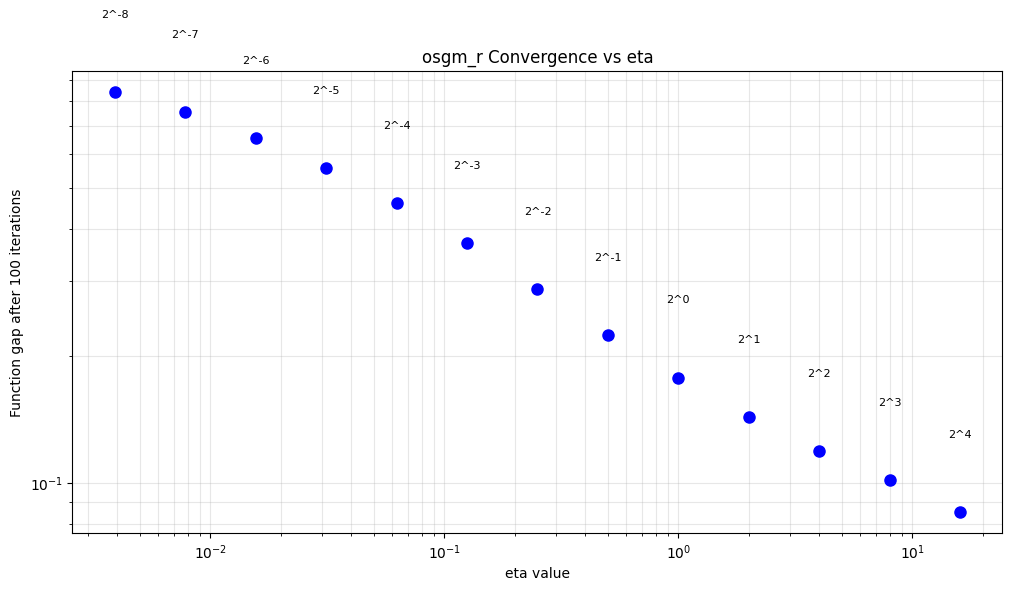

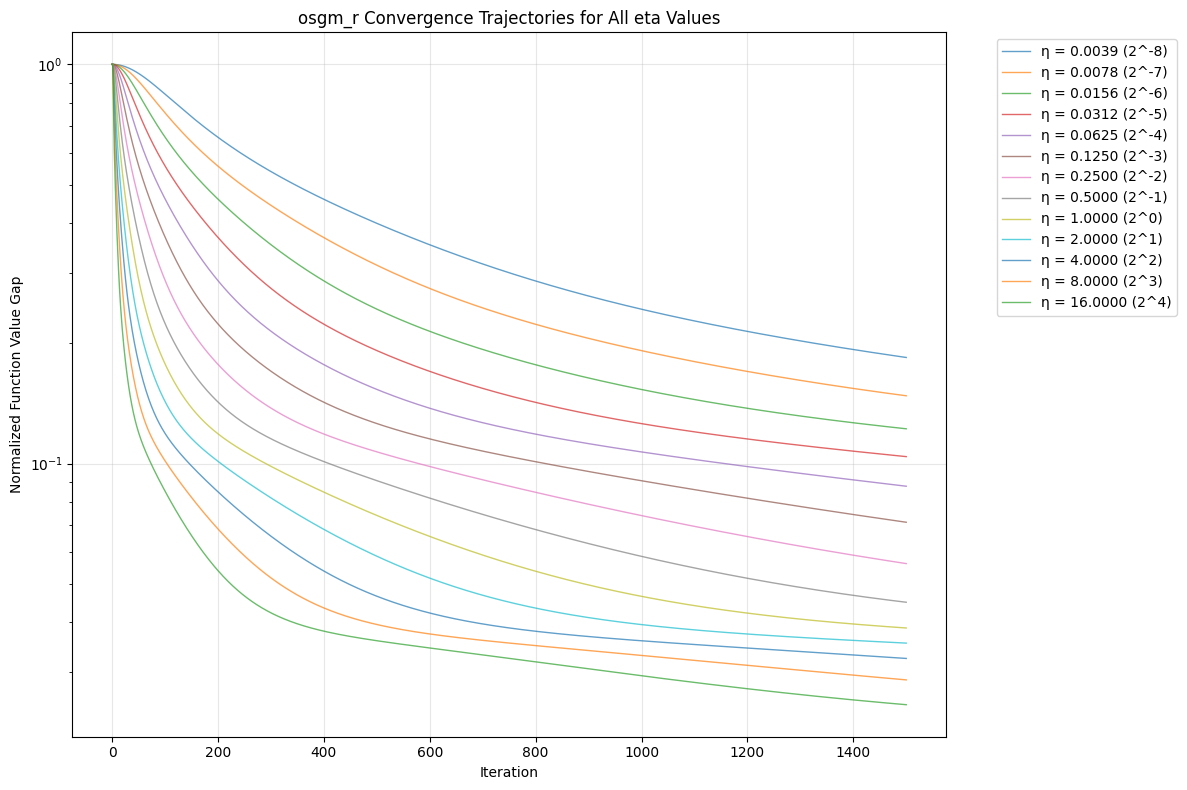

Sigma: 0.001
Testing osgm_r with 14 eta values
Eta range: from 0.003906 to 32.000000
1390348.7443897058
1335814.8375100244
1223340.5633127776
1050851.4169808573
845223.069763462
635957.2645332946
452944.7140910566
308350.18428160495
199590.62647538466
118160.32818861917
57350.437265517
19004.985682248098
5823.073306472568
2321.9939690068395


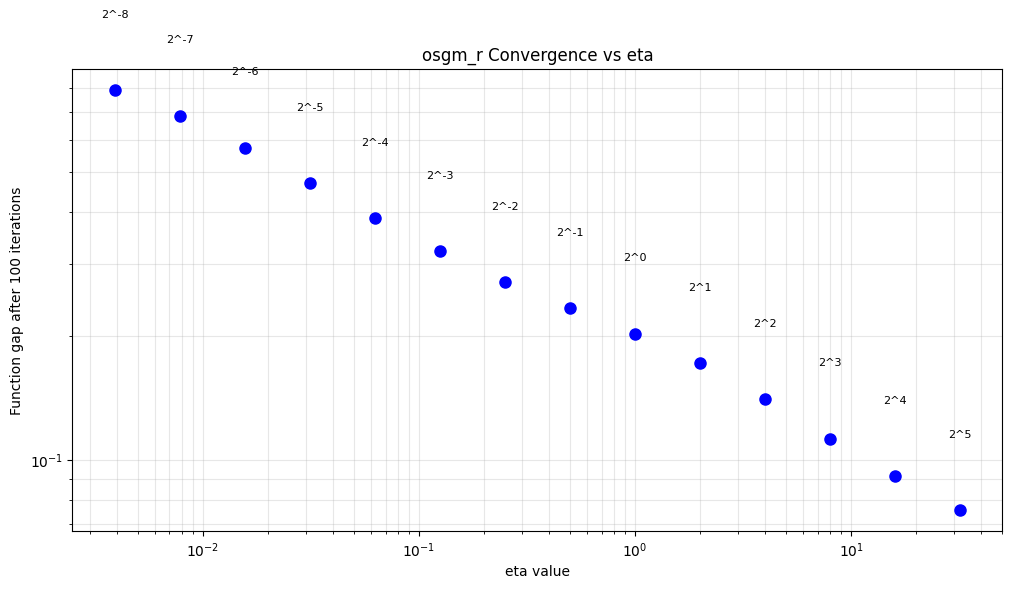

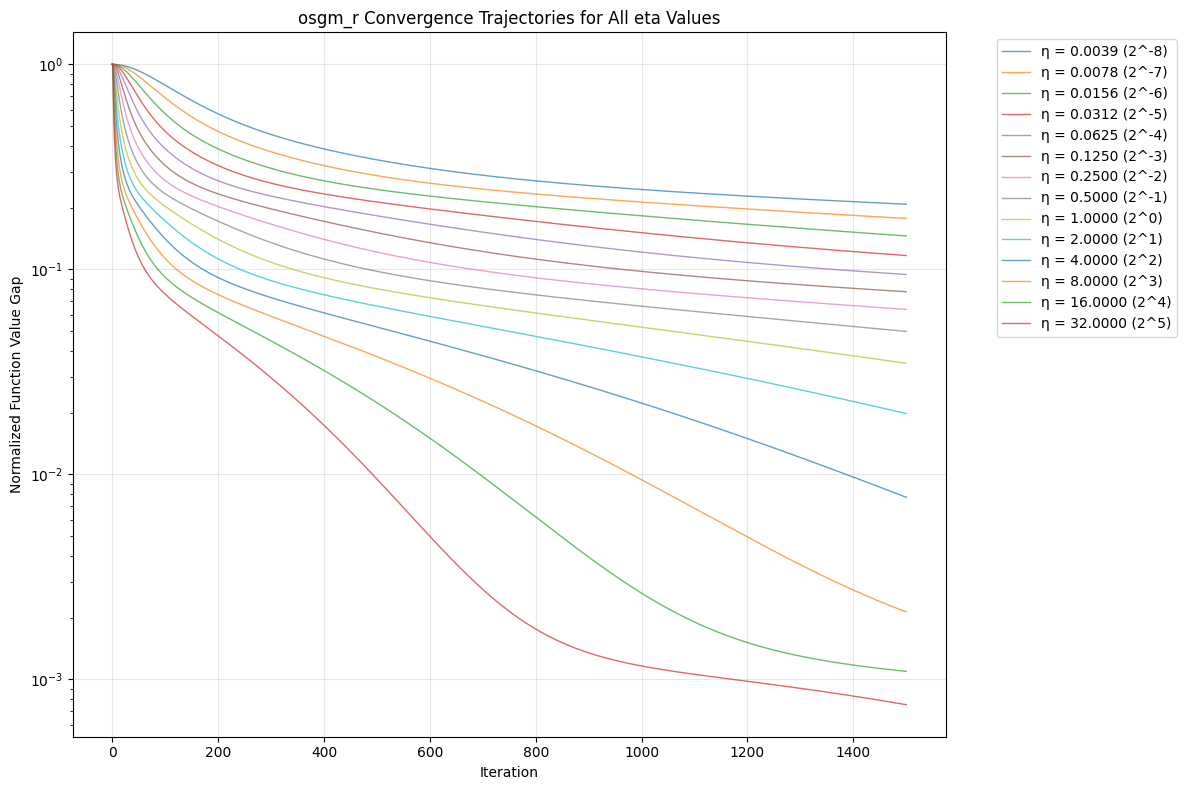

Sigma: 0.01
Testing osgm_r with 13 eta values
Eta range: from 0.003906 to 16.000000
100441.93552292862
58467.69726727284
28230.548466057495
18991.427797889264
10861.391425604212
5144.363124016206
2277.2718169628615
829.6038695332719
293.81993963226114
138.00961017863415
109.151425420703
OSGM-R converged at iteration 1410 with gradient norm 8.13e-07 and function gap 9.95e-11
107.73211898265215
OSGM-R converged at iteration 999 with gradient norm 8.03e-07 and function gap 9.70e-11
104.98441272531458


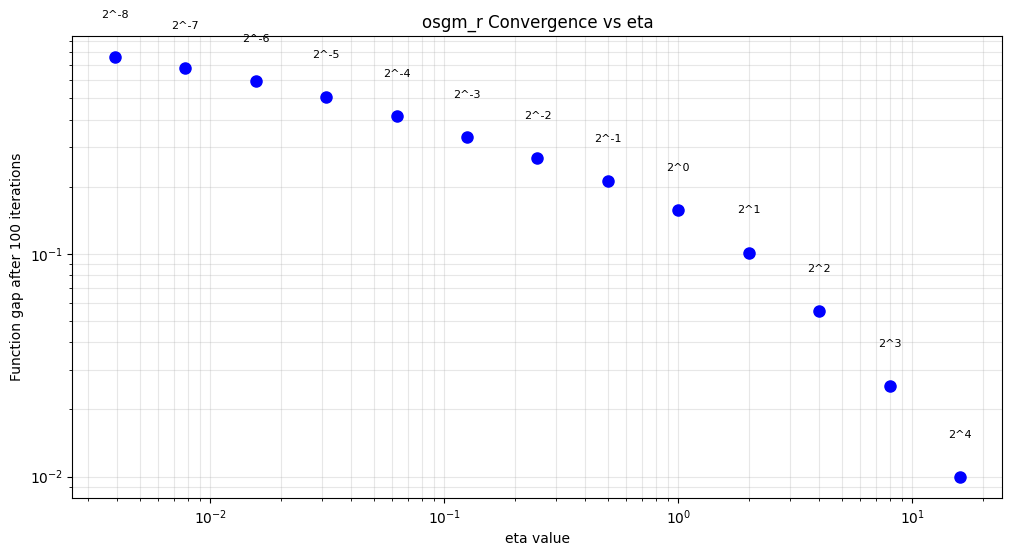

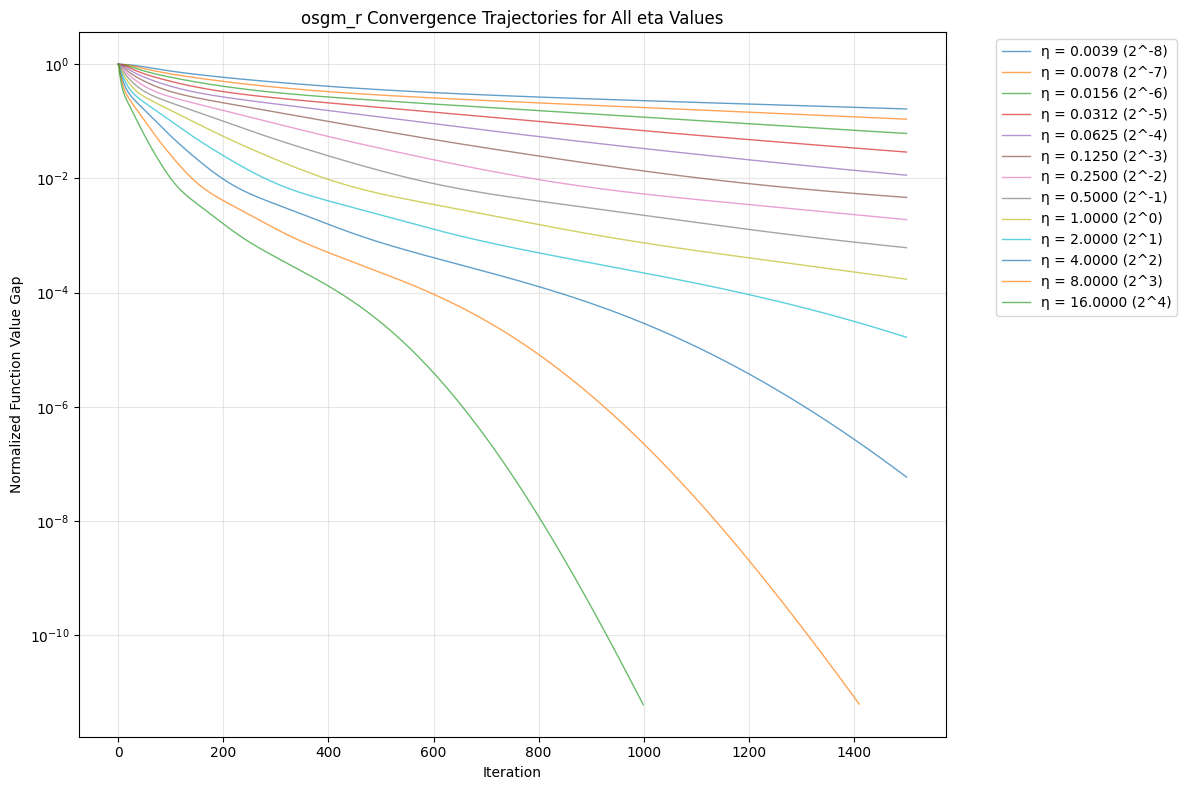

Sigma: 0.1
Testing osgm_r with 13 eta values
Eta range: from 0.003906 to 16.000000
25962.807110919613
15296.252486331787
6243.605529971675
3186.066513862028
838.0765688274149
14.920181095119286
OSGM-R converged at iteration 1115 with gradient norm 2.80e-06 and function gap 9.95e-11
15.5882072569361
OSGM-R converged at iteration 789 with gradient norm 2.80e-06 and function gap 9.96e-11
15.603522208715484
OSGM-R converged at iteration 559 with gradient norm 2.75e-06 and function gap 9.59e-11
15.638874740892428
OSGM-R converged at iteration 396 with gradient norm 2.73e-06 and function gap 9.46e-11
15.67565331027365
OSGM-R converged at iteration 281 with gradient norm 2.65e-06 and function gap 8.93e-11
15.738753545962116
OSGM-R converged at iteration 199 with gradient norm 2.74e-06 and function gap 9.55e-11
15.763065245839698
OSGM-R converged at iteration 142 with gradient norm 2.48e-06 and function gap 7.87e-11
15.762890801626273


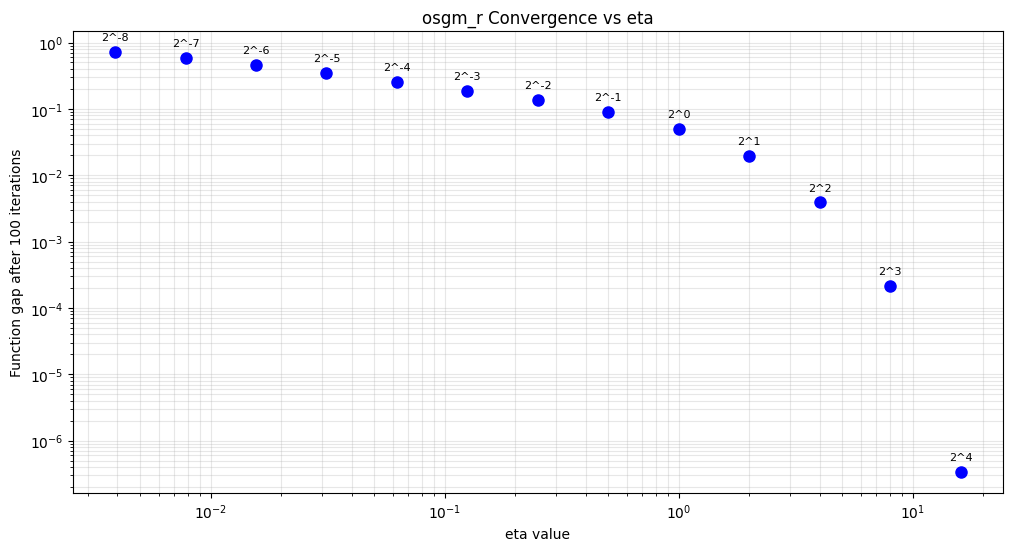

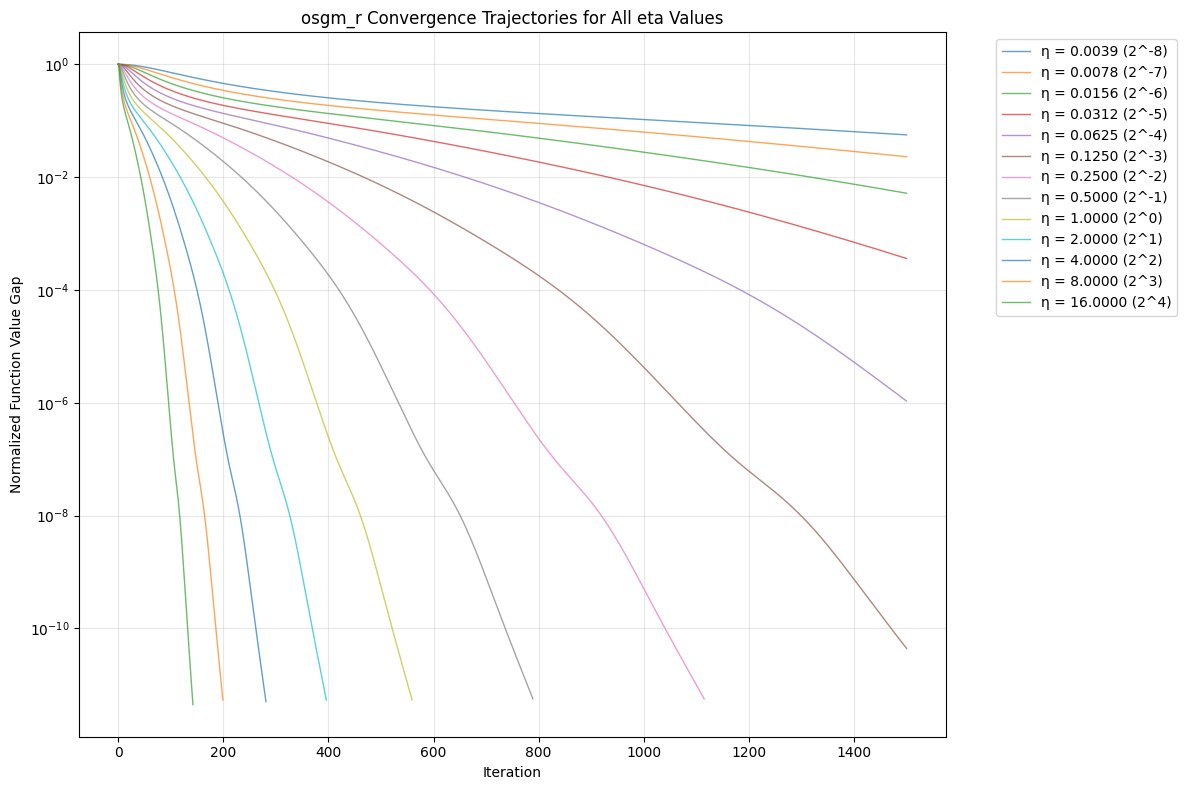

In [259]:
eta_range_osgm_r = [[2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 6)], [2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 5)]]
for i in range(len(sigmas)):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_r= plot_eta_convergence_analysis(
      'osgm_r', eta_range_osgm_r[i], f, grad_f, x_init, K, f_star, P_i
  )


Sigma: 0.0001
Testing osgm_g with 13 eta values
Eta range: from 0.003906 to 16.000000
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


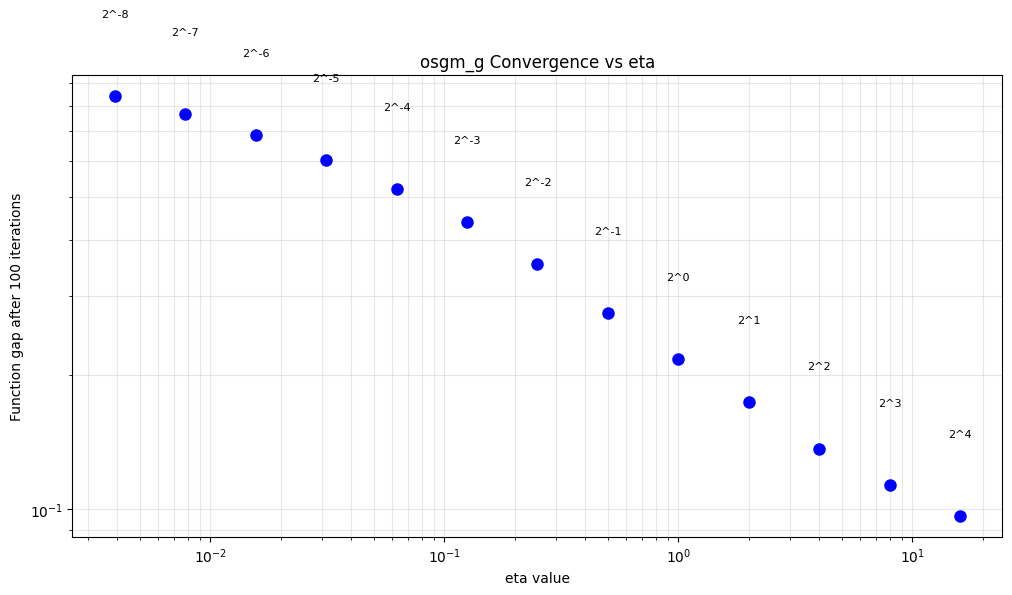

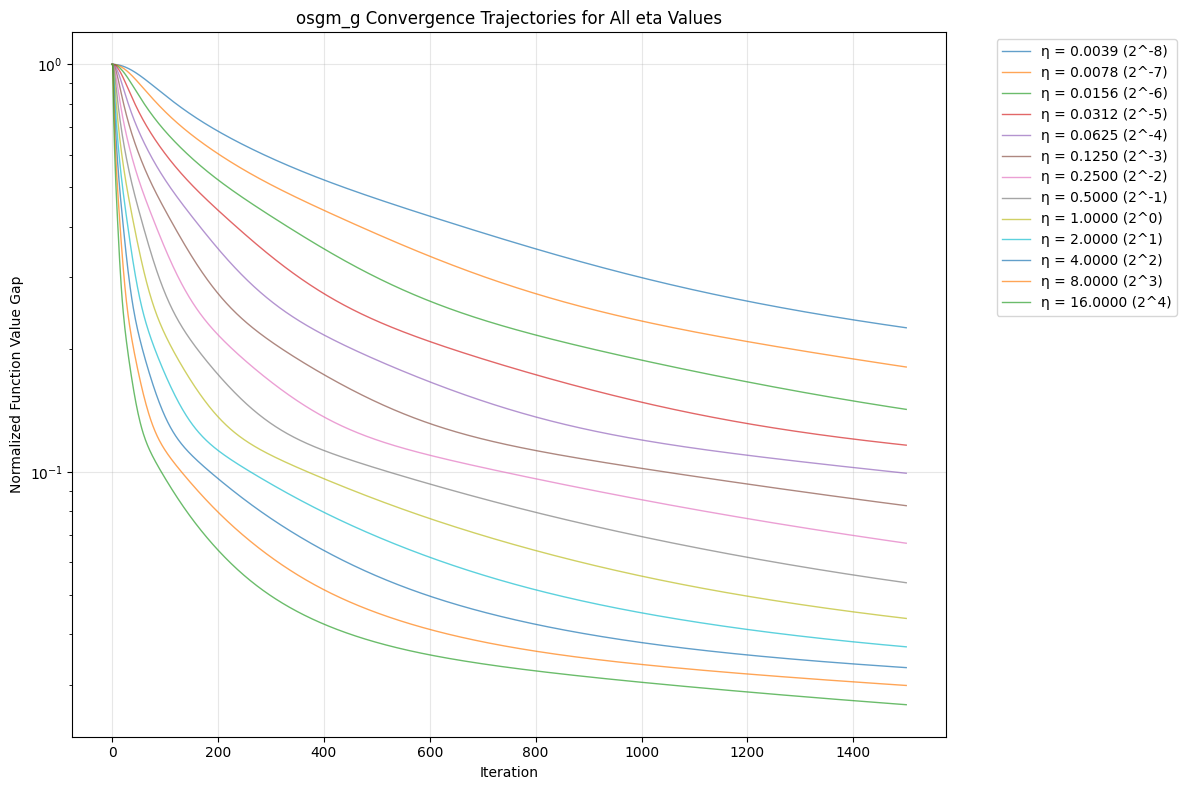

Sigma: 0.001
Testing osgm_g with 13 eta values
Eta range: from 0.003906 to 16.000000
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
79854.35874794384
47776.65030095906
19470.870969345135


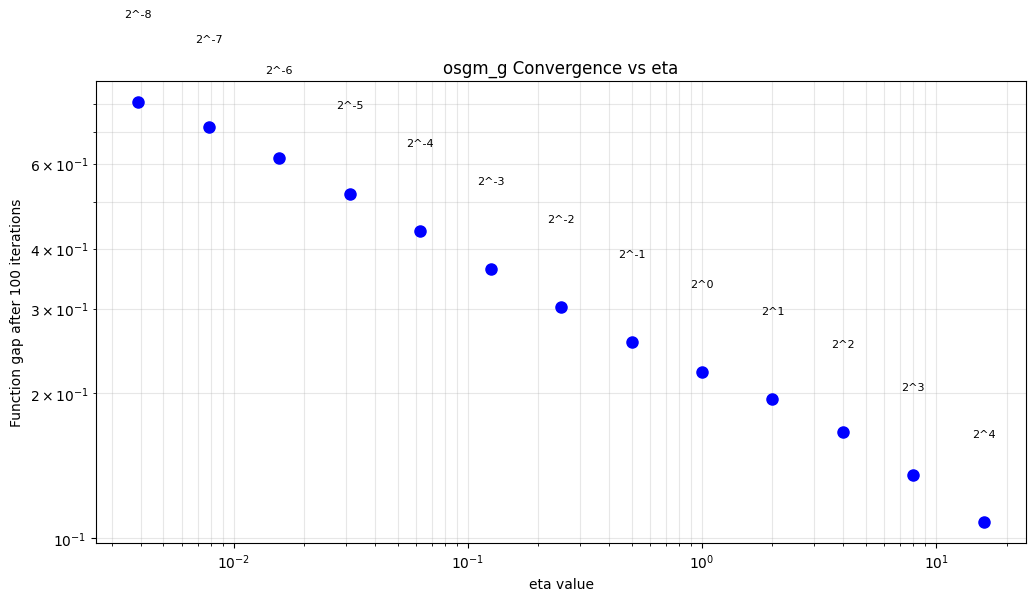

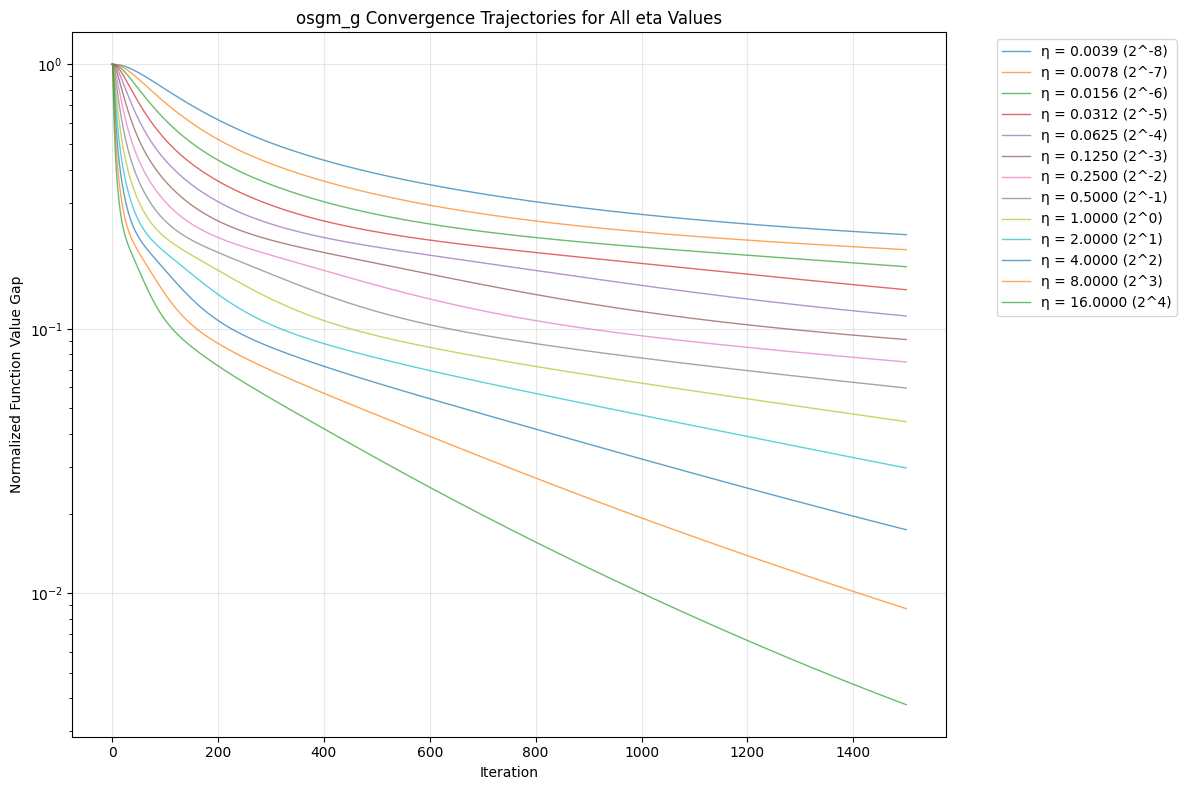

Sigma: 0.01
Testing osgm_g with 12 eta values
Eta range: from 0.003906 to 8.000000
inf
inf
inf
124678.2956036085
51483.64006583321
21177.555945834327
9585.462297923044
4585.140649799317
2370.6033430872644
1225.1609570412243
916.7506192563993
792.592328368772


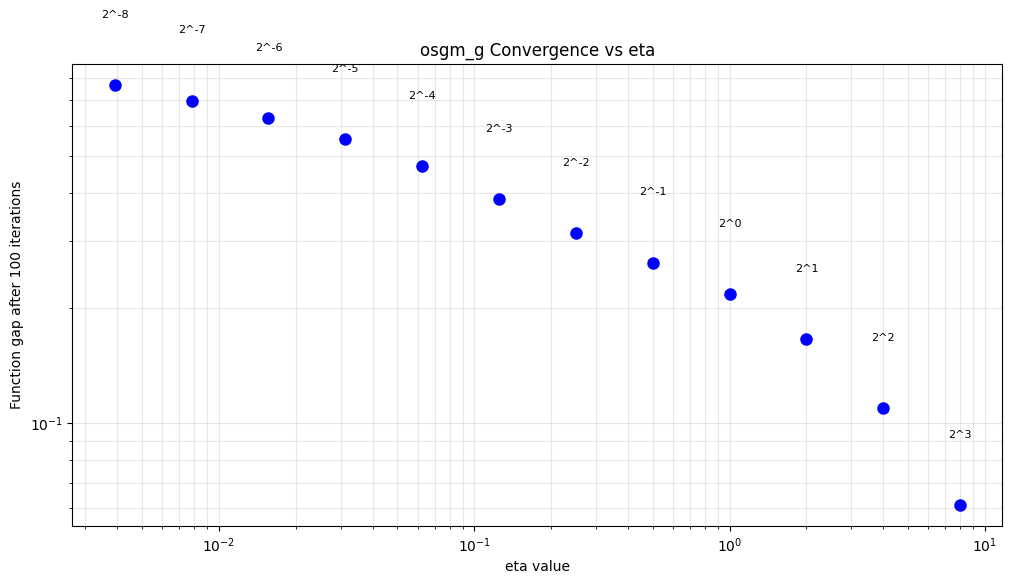

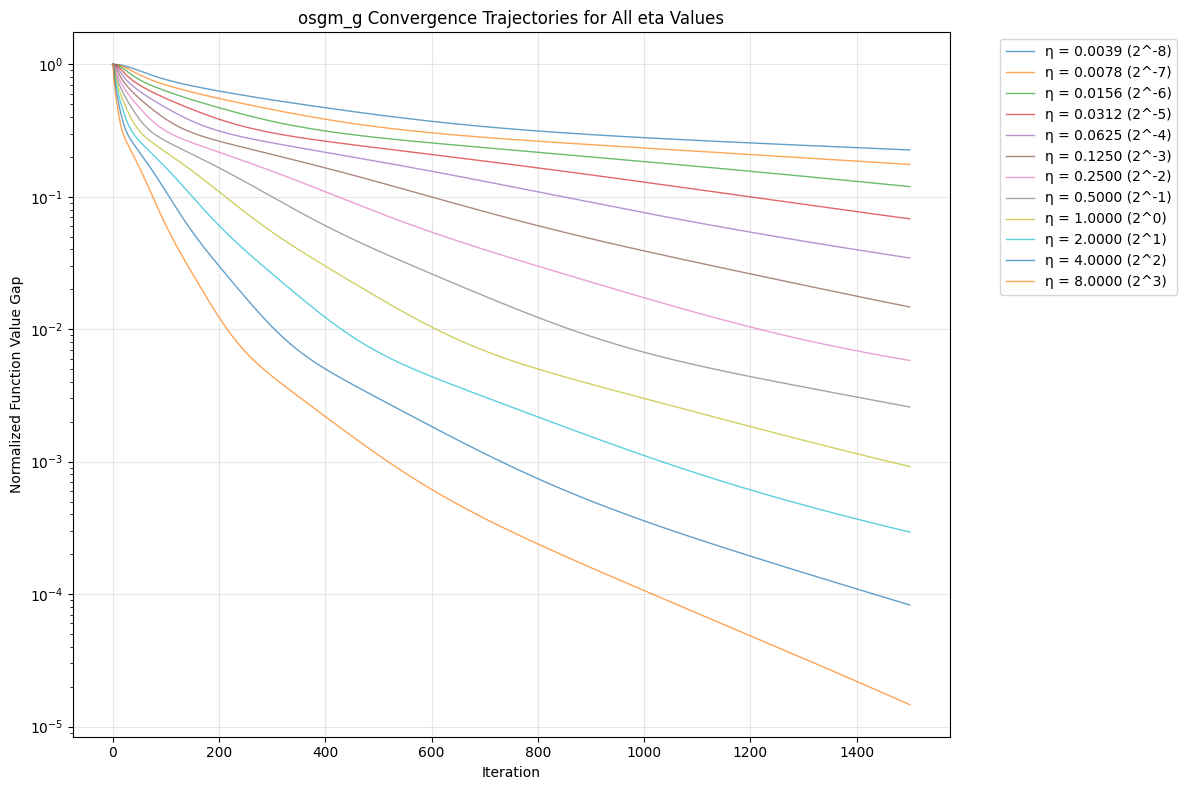

Sigma: 0.1
Testing osgm_g with 12 eta values
Eta range: from 0.003906 to 8.000000
inf
15233.031865325309
7289.043039962746
2771.727943682097
2016.4614974335718
2361.0819052839115
49.90578044839253
55.7556500782884
OSGM-G converged at iteration 1389 with gradient norm 9.90e-11
55.69459821612777
OSGM-G converged at iteration 980 with gradient norm 9.94e-11
55.595324453143746
OSGM-G converged at iteration 691 with gradient norm 9.94e-11
55.44481940585619
inf


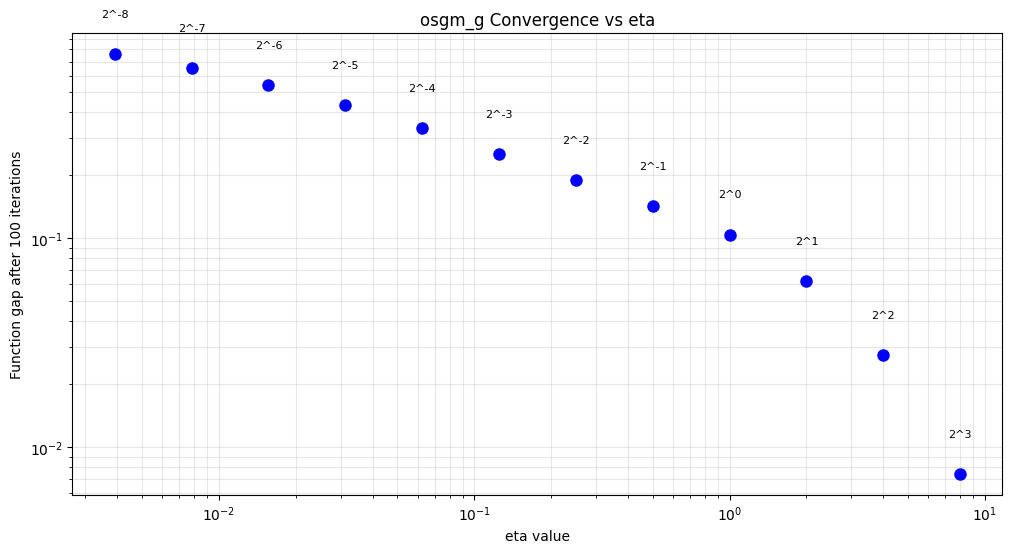

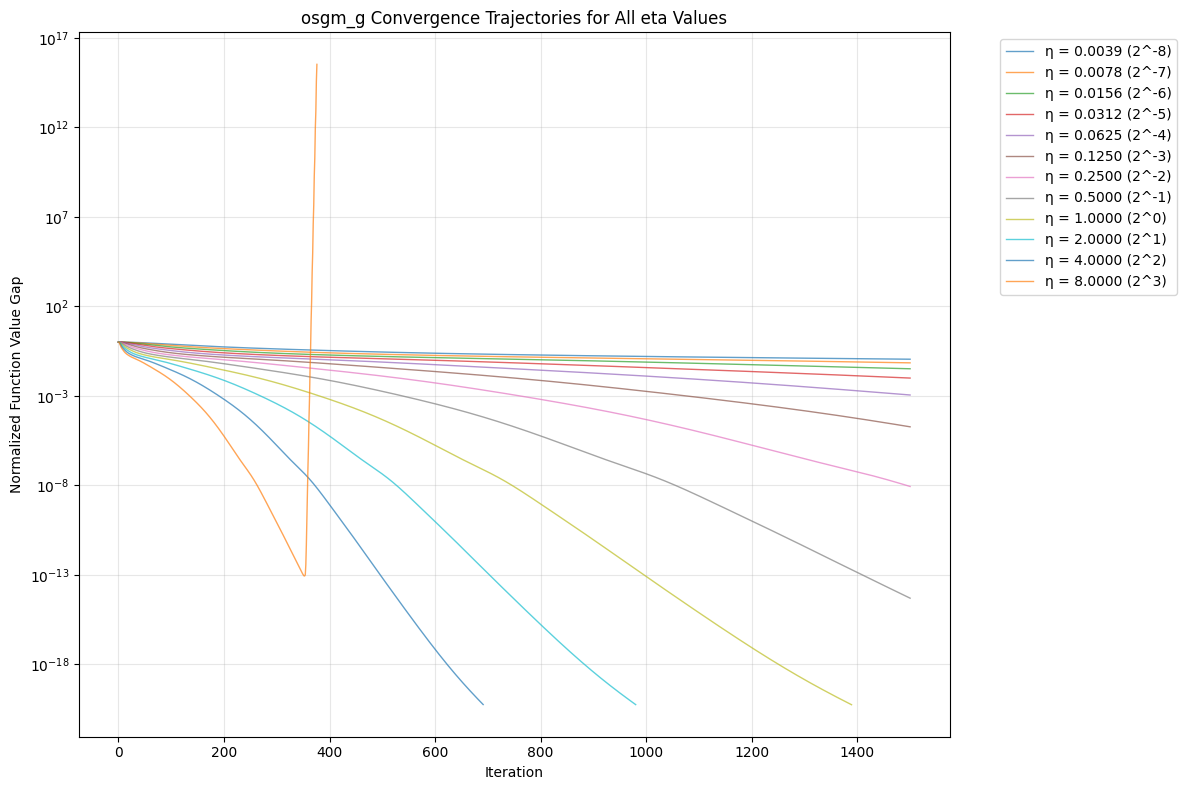

In [260]:
eta_range_osgm_g = [[2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 5)], [2.0 ** exp for exp in range(-8, 4)], [2.0 ** exp for exp in range(-8, 4)]]
for i in range(len(sigmas)):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_g= plot_eta_convergence_analysis(
      'osgm_g', eta_range_osgm_g[i], f, grad_f, x_init, K, f_star, P_i, A=A
  )


Sigma: 0.0001
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
852031.7037191385
697013.1456957494
536939.5003150076
236827.61212569708
112315.29271451876
137411.69066487404
212069.43745353687
283990.7449292997
9445.468156024155


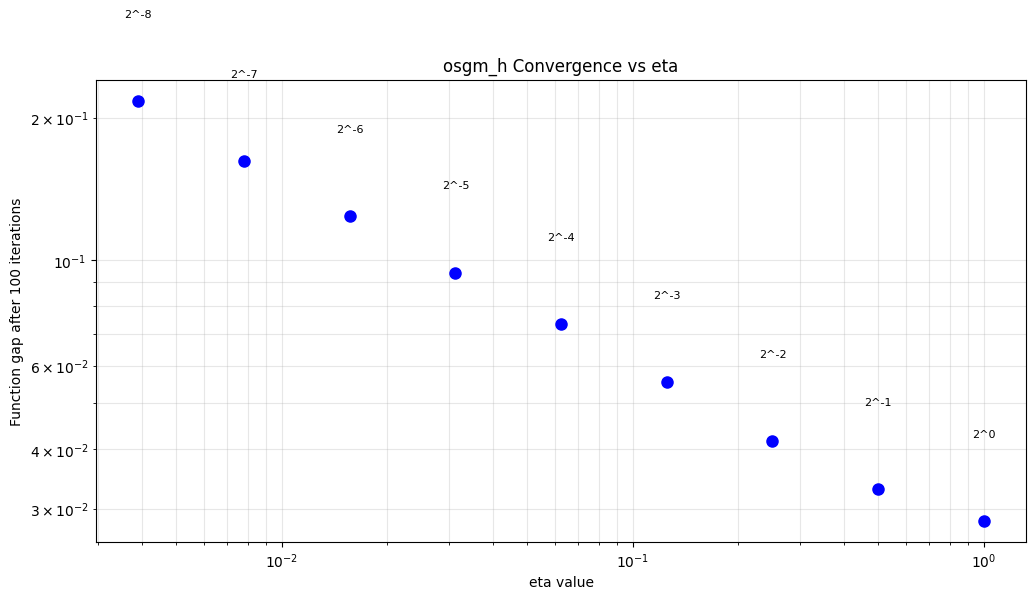

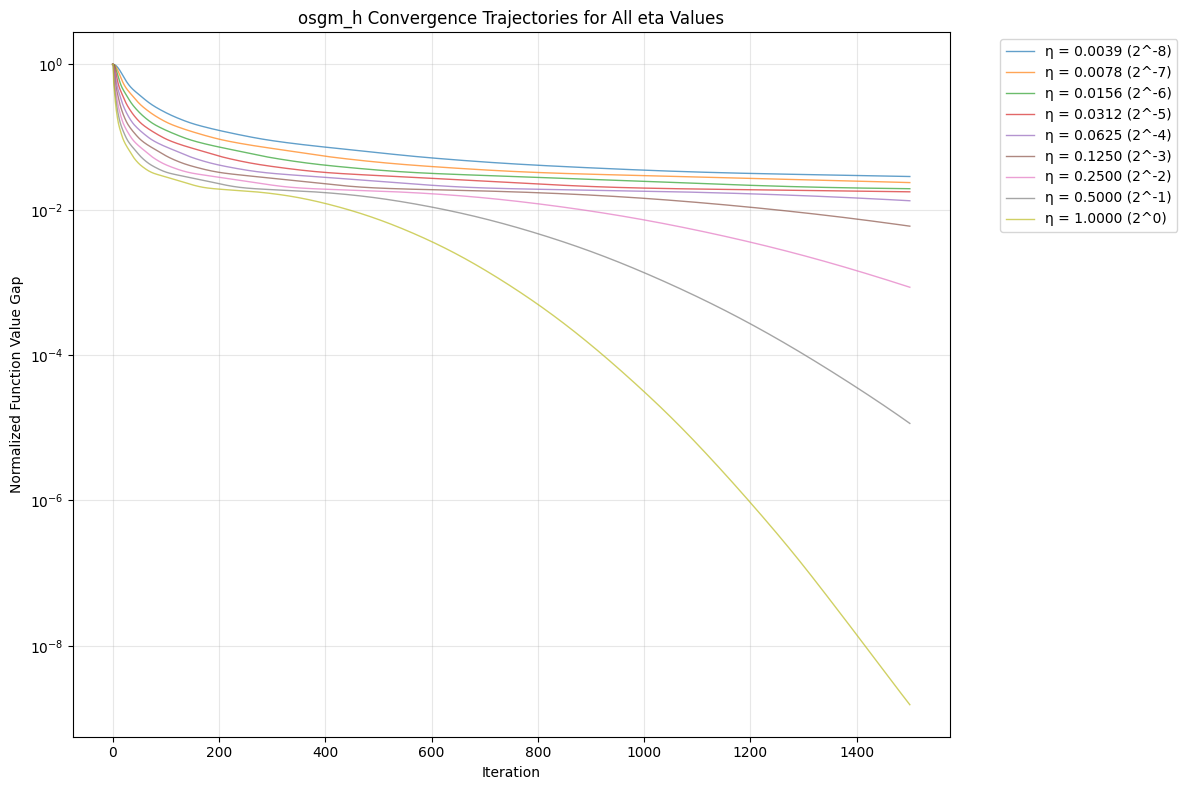

Sigma: 0.001
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
5882.270844246895
1398.5185612095197
825.6293385385196
784.6408126412757
778.5520011104144
480.03009038466337
372.8016439519036
OSGM-H converged at iteration 1216 with gradient norm 9.84e-11
405.13763830117256
OSGM-H converged at iteration 862 with gradient norm 9.80e-11
416.32871756732345


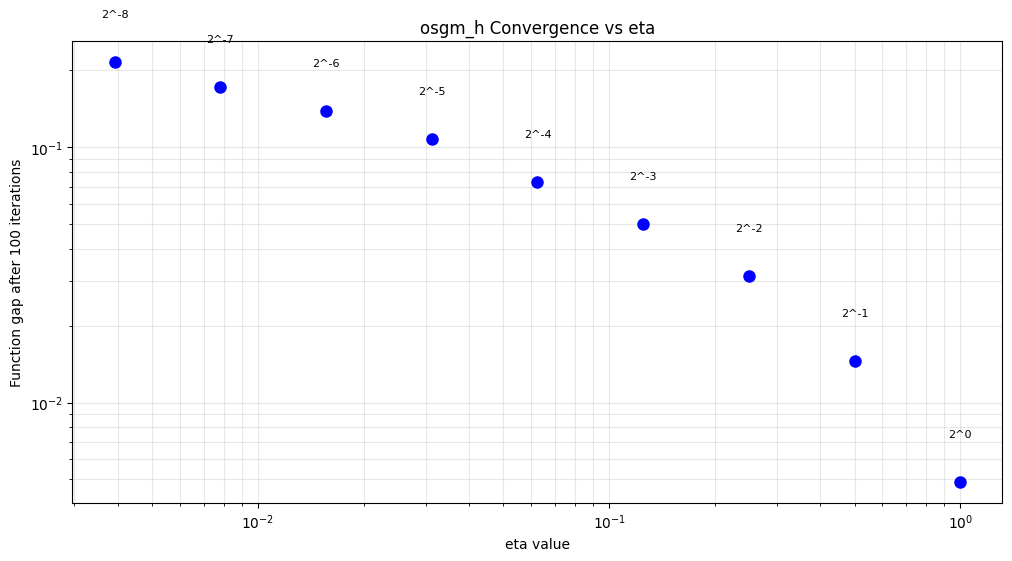

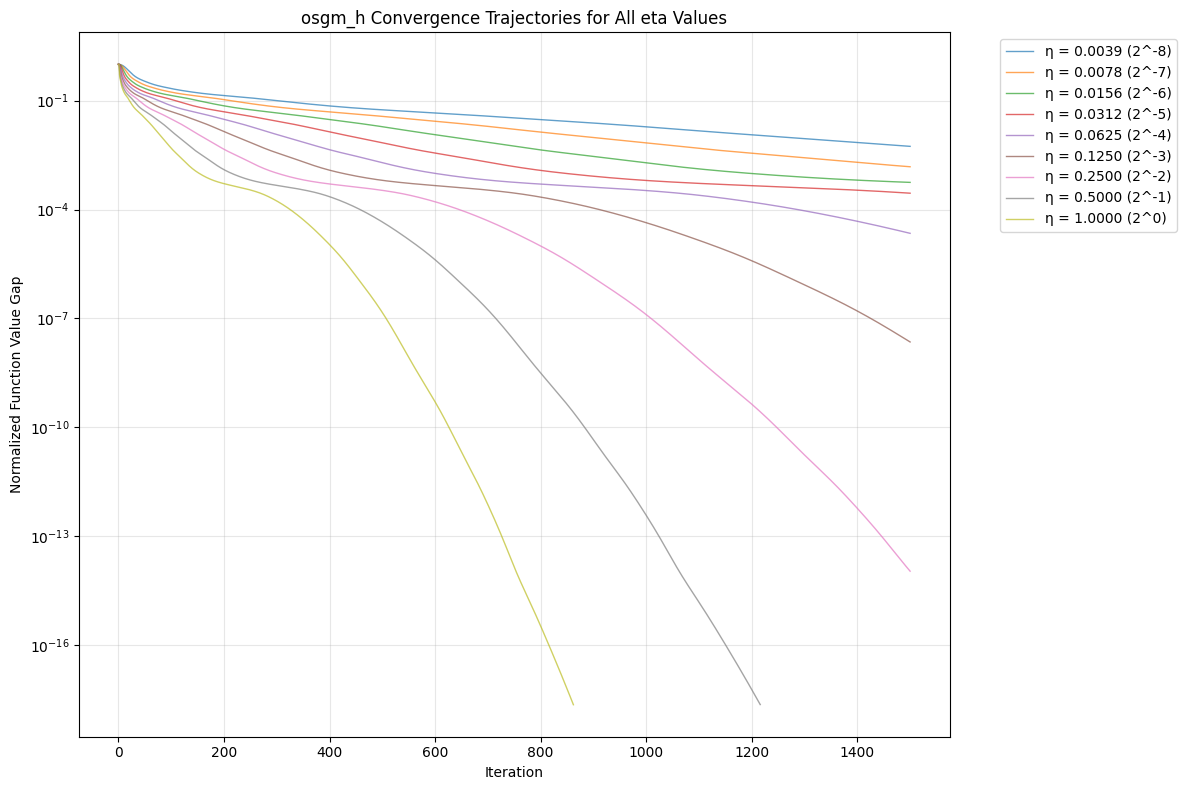

Sigma: 0.01
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
81.7716317851107
42.568504198723865
33.37103134954782
24.05071339330193
OSGM-H converged at iteration 1380 with gradient norm 9.75e-11
19.663607659625235
OSGM-H converged at iteration 977 with gradient norm 9.69e-11
19.841058358718897
OSGM-H converged at iteration 692 with gradient norm 9.66e-11
20.138799916760043
OSGM-H converged at iteration 491 with gradient norm 9.42e-11
20.574419081317323
OSGM-H converged at iteration 349 with gradient norm 9.50e-11
21.484080726464217


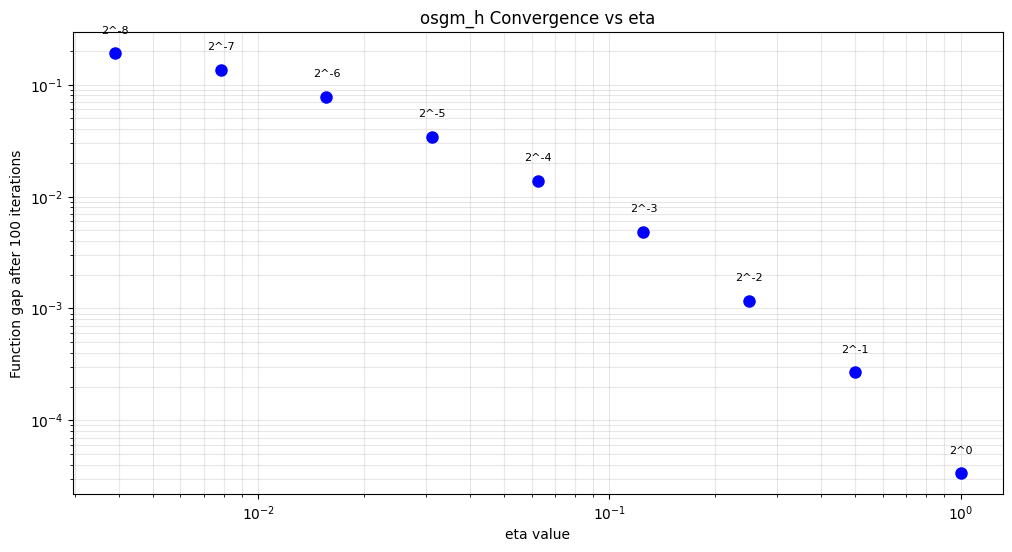

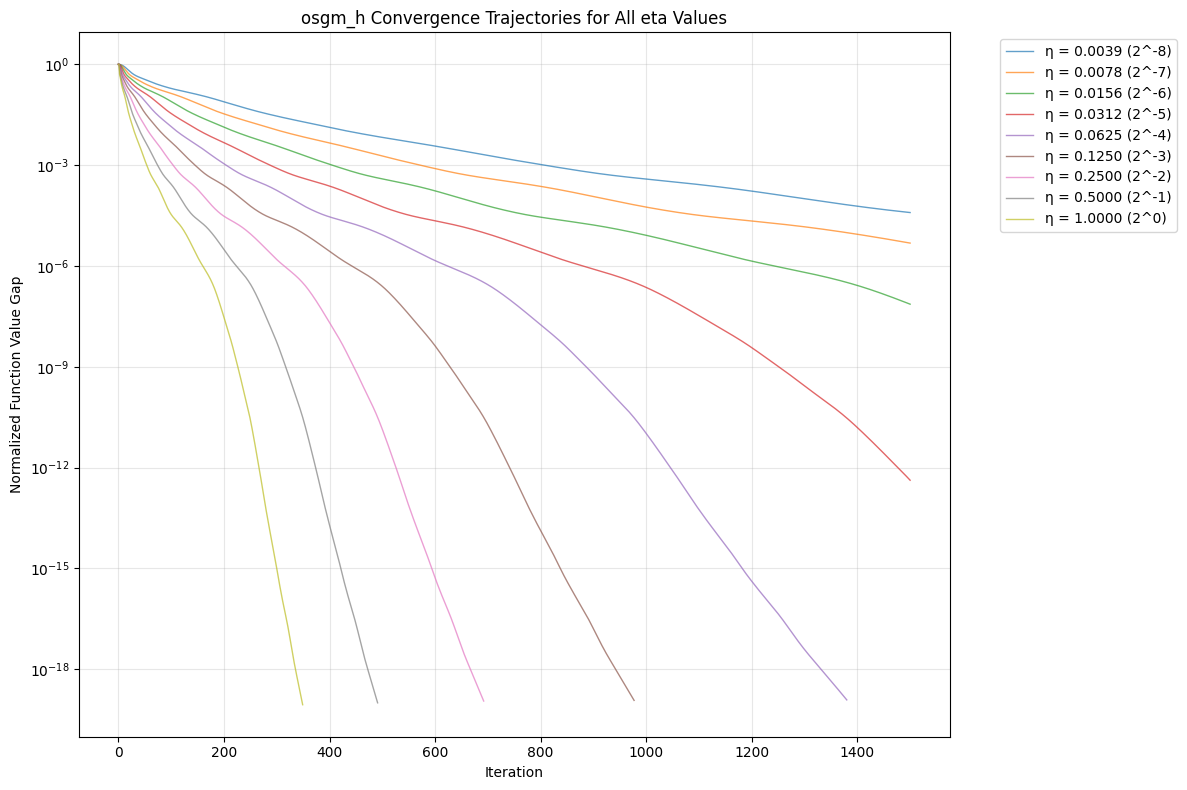

Sigma: 0.1
Testing osgm_h with 9 eta values
Eta range: from 0.003906 to 1.000000
75.4402855201541
36.21108264376435
OSGM-H converged at iteration 1275 with gradient norm 9.83e-11
21.508250089341566
OSGM-H converged at iteration 904 with gradient norm 9.93e-11
21.30264909824958
OSGM-H converged at iteration 642 with gradient norm 9.91e-11
21.003586869926814
OSGM-H converged at iteration 457 with gradient norm 9.72e-11
20.58004385247976
OSGM-H converged at iteration 326 with gradient norm 9.67e-11
20.019600398441344
OSGM-H converged at iteration 234 with gradient norm 8.87e-11
19.32779716078362
OSGM-H converged at iteration 169 with gradient norm 8.89e-11
18.53617386496169


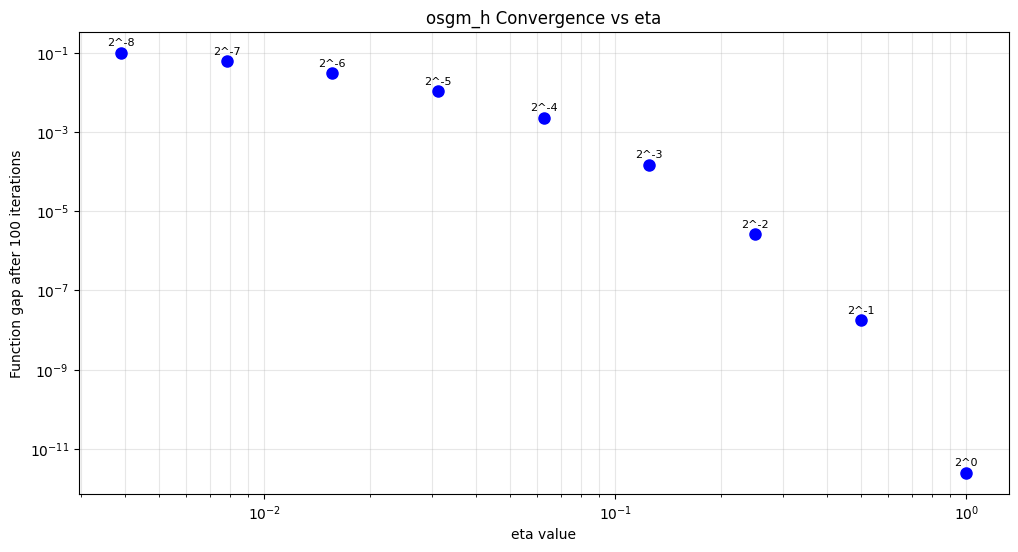

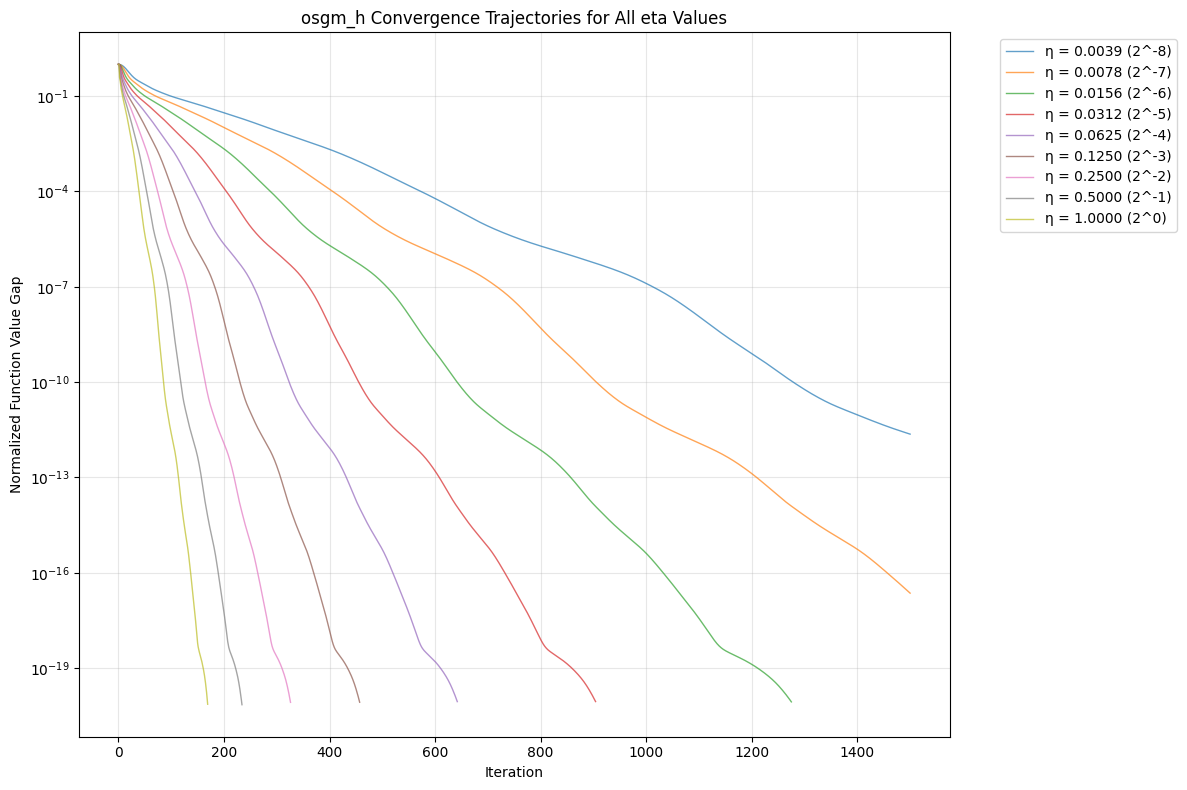

In [261]:
eta_range_osgm_h = [[2.0 ** exp for exp in range(-8, 1)], [2.0 ** exp for exp in range(-8, 1)], [2.0 ** exp for exp in range(-8, 1)], [2.0 ** exp for exp in range(-8, 1)], [2.0 ** exp for exp in range(-8, 1)]]
for i in range(len(sigmas)):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_h = plot_eta_convergence_analysis(
      'osgm_h', eta_range_osgm_h[i], f, grad_f, x_init, K, f_star, P_i
  )

Sigma: 0.0001
Testing osgm_r_accelerated with 6 eta values
Eta range: from 0.000244 to 0.007812


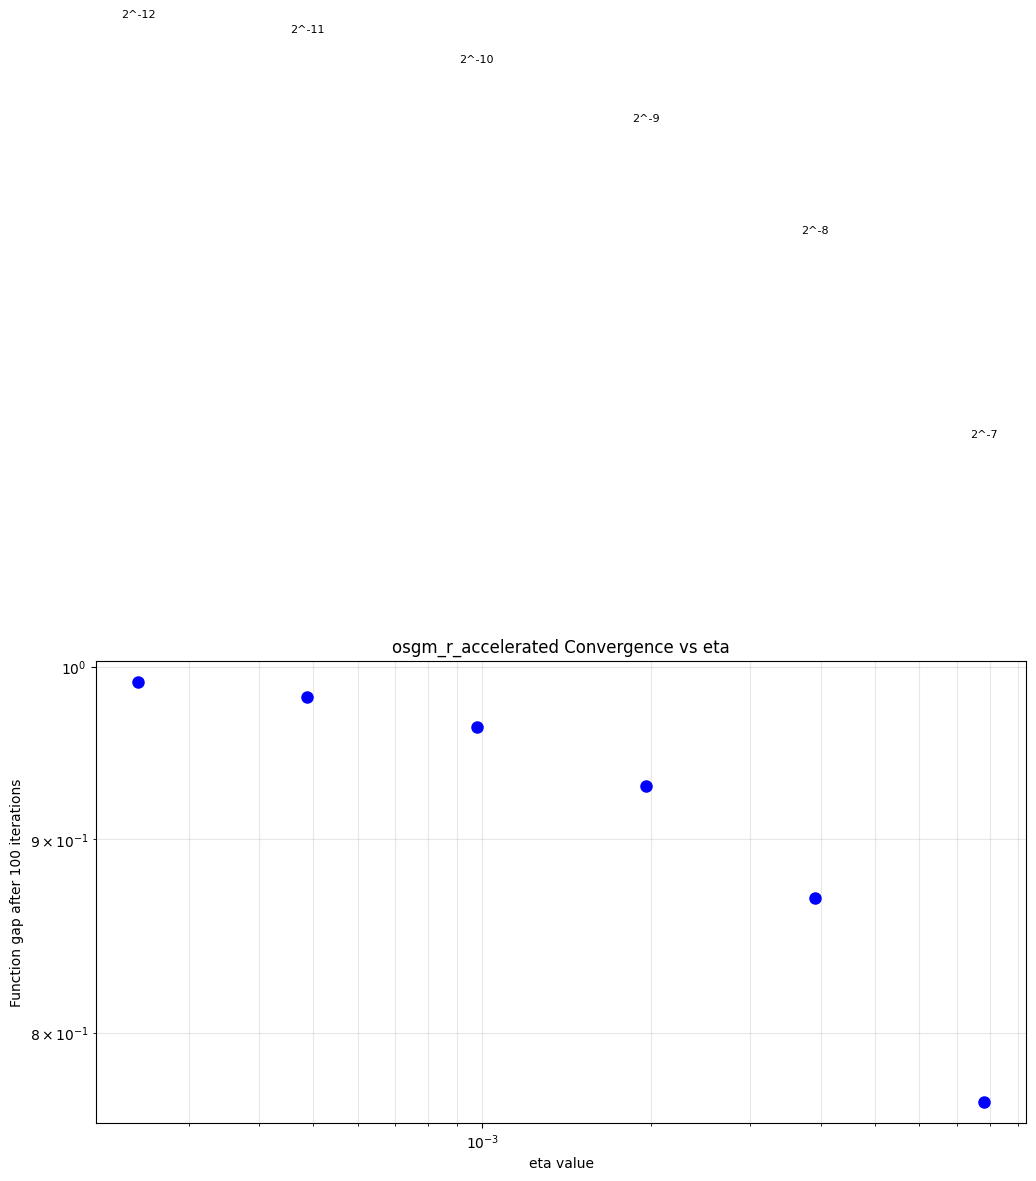

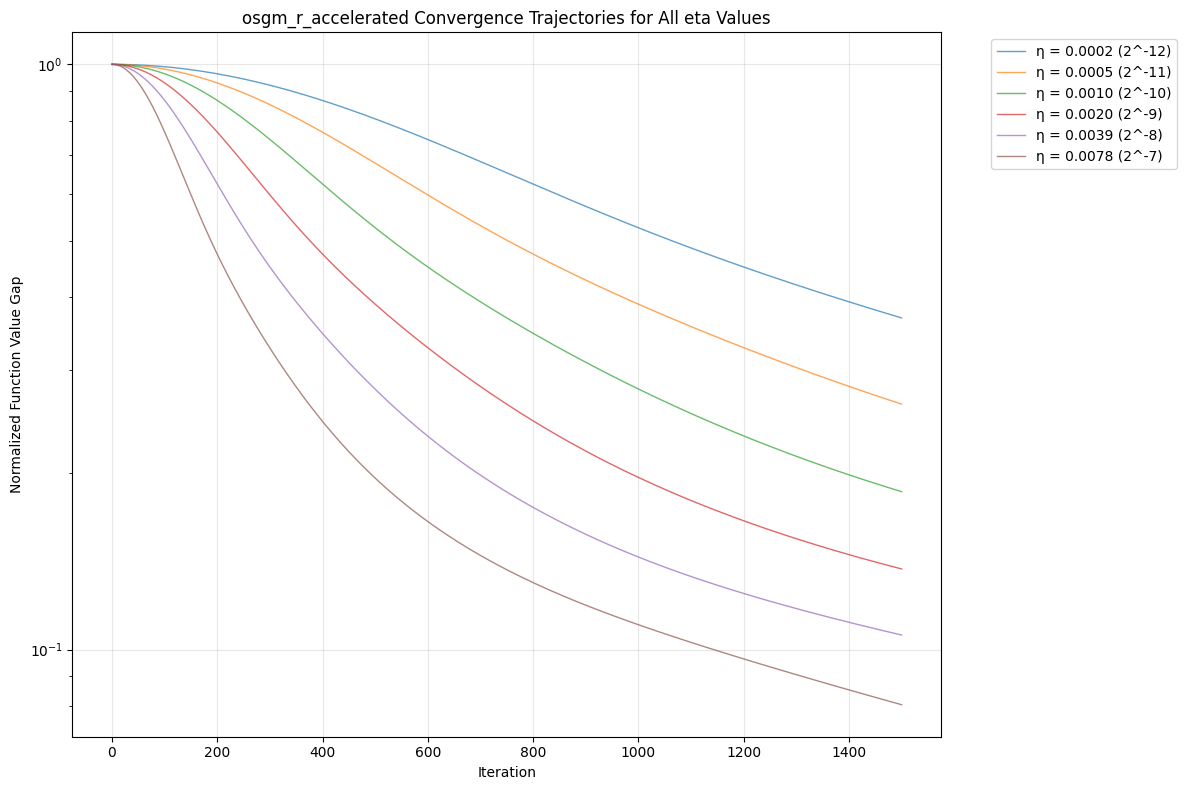

Sigma: 0.001
Testing osgm_r_accelerated with 8 eta values
Eta range: from 0.000244 to 0.031250


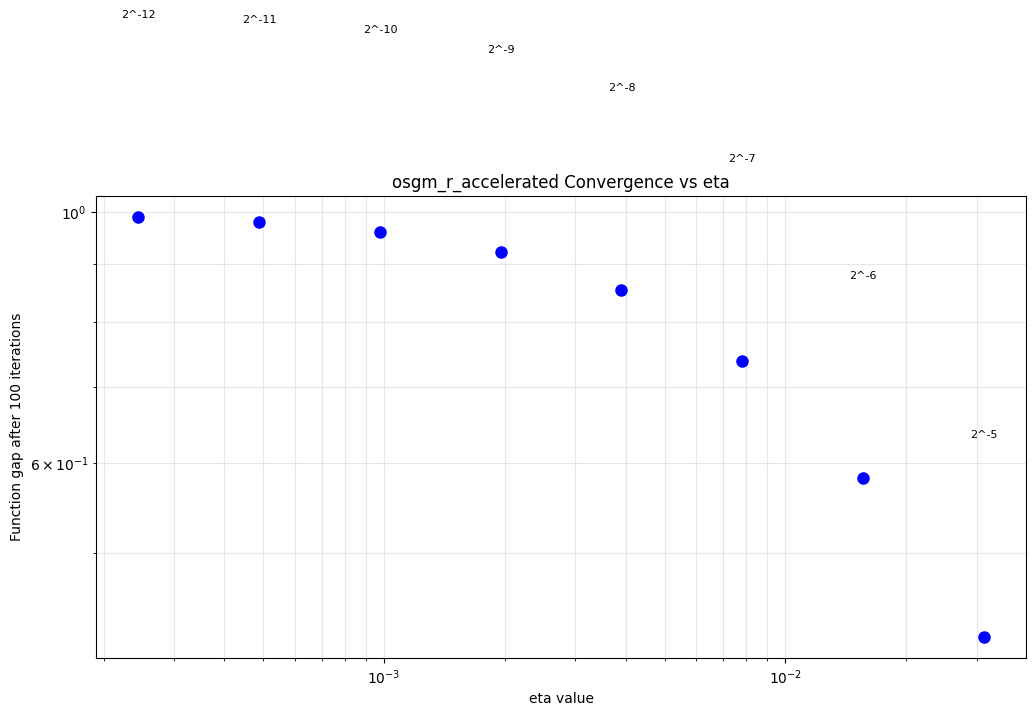

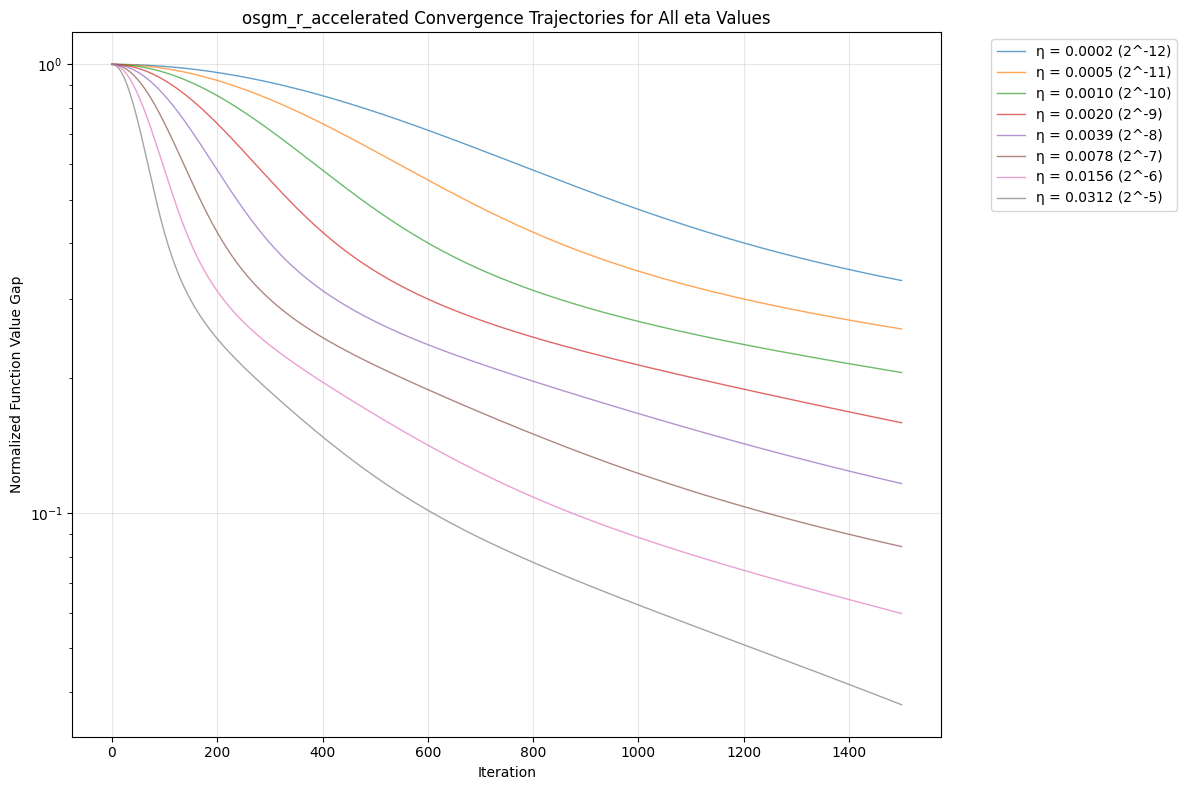

Sigma: 0.01
Testing osgm_r_accelerated with 5 eta values
Eta range: from 0.003906 to 0.062500


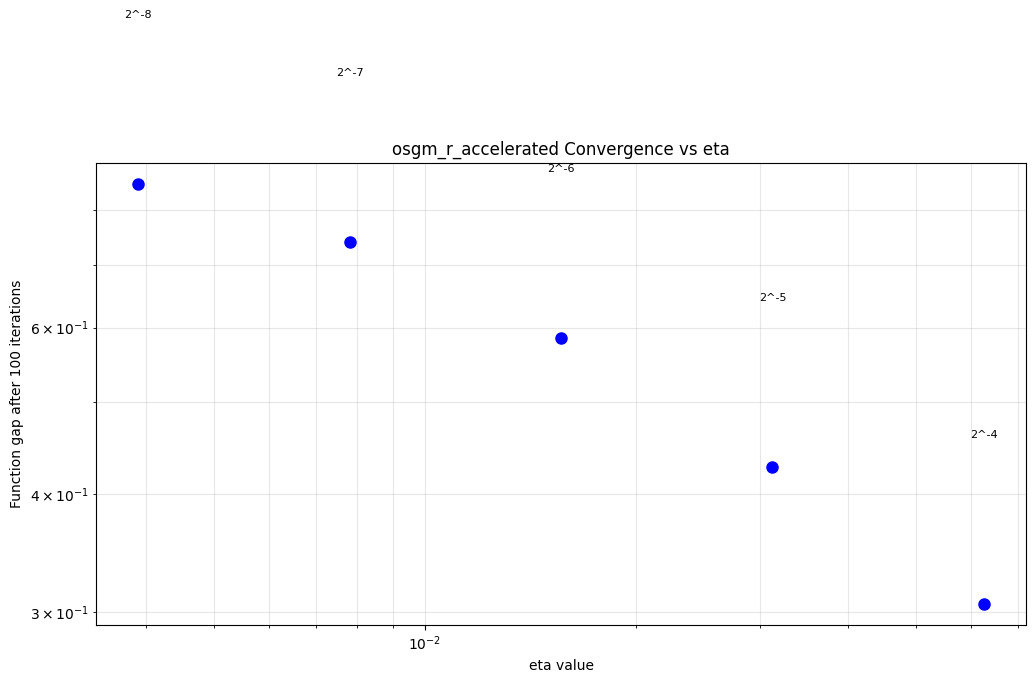

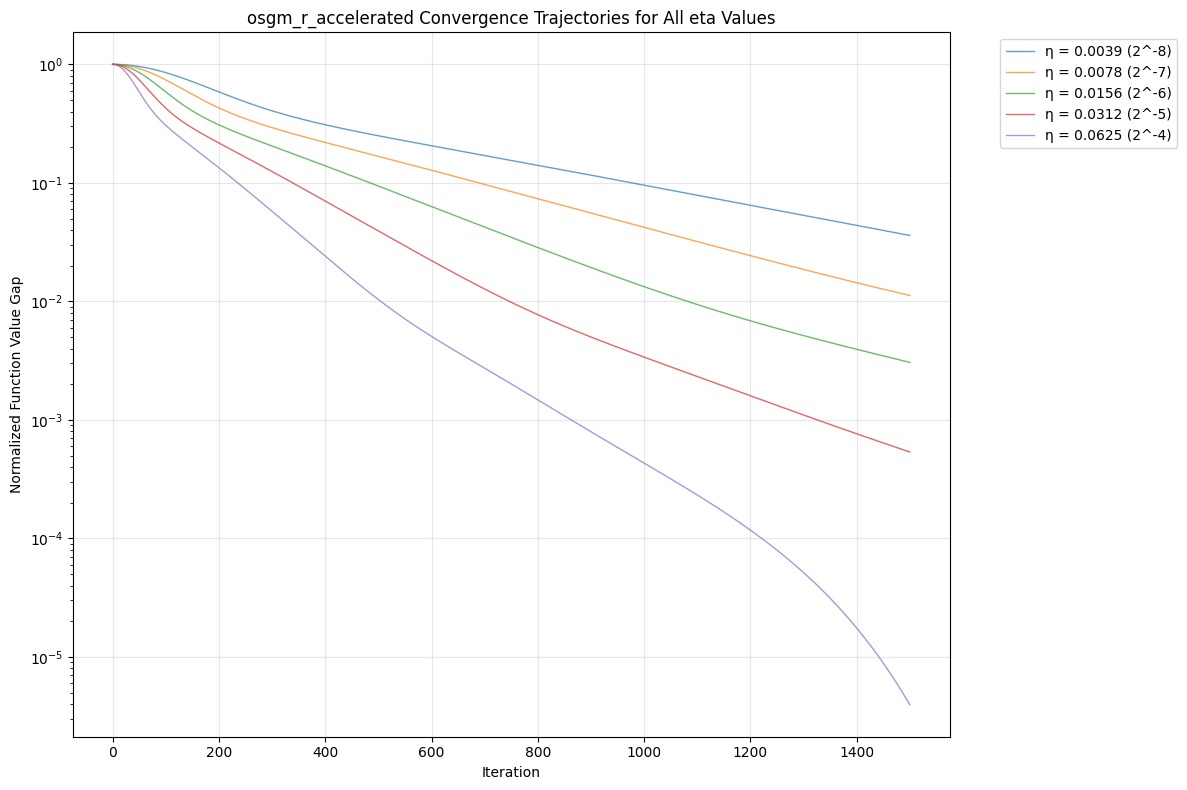

Sigma: 0.1
Testing osgm_r_accelerated with 13 eta values
Eta range: from 0.003906 to 16.000000
OSGM_R_Accelerated converged at iteration 1202 with grad_norm=3.32e-06 and f_gap=9.55e-11
OSGM_R_Accelerated converged at iteration 801 with grad_norm=3.20e-06 and f_gap=9.71e-11
OSGM_R_Accelerated converged at iteration 520 with grad_norm=2.85e-06 and f_gap=9.23e-11
OSGM_R_Accelerated converged at iteration 321 with grad_norm=2.20e-06 and f_gap=8.44e-11
OSGM_R_Accelerated converged at iteration 209 with grad_norm=2.75e-06 and f_gap=7.26e-11
OSGM_R_Accelerated converged at iteration 175 with grad_norm=3.04e-06 and f_gap=9.19e-11
OSGM_R_Accelerated converged at iteration 136 with grad_norm=2.62e-06 and f_gap=7.19e-11
OSGM_R_Accelerated converged at iteration 100 with grad_norm=2.33e-06 and f_gap=8.37e-11
OSGM_R_Accelerated converged at iteration 77 with grad_norm=3.13e-06 and f_gap=4.72e-11
OSGM_R_Accelerated converged at iteration 58 with grad_norm=1.88e-06 and f_gap=6.02e-11


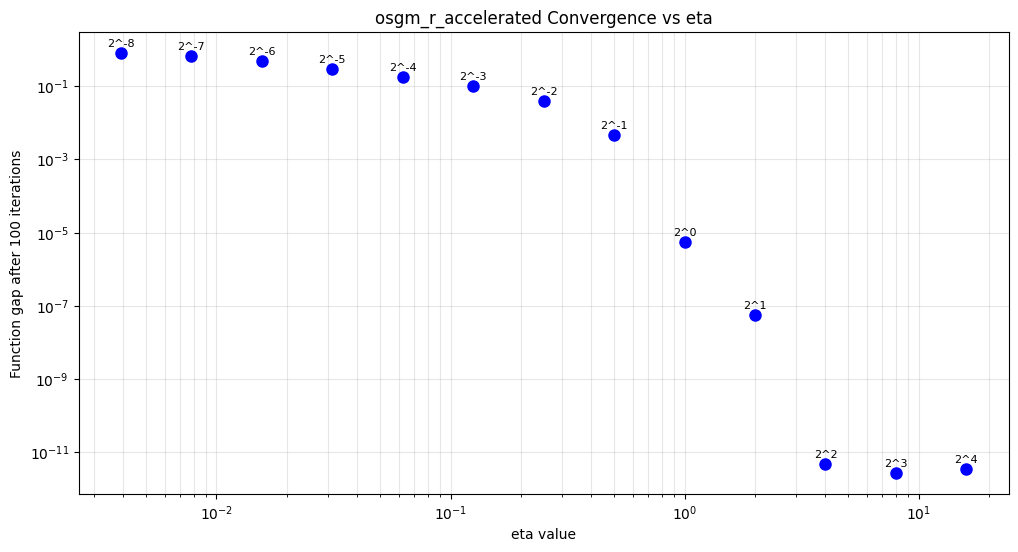

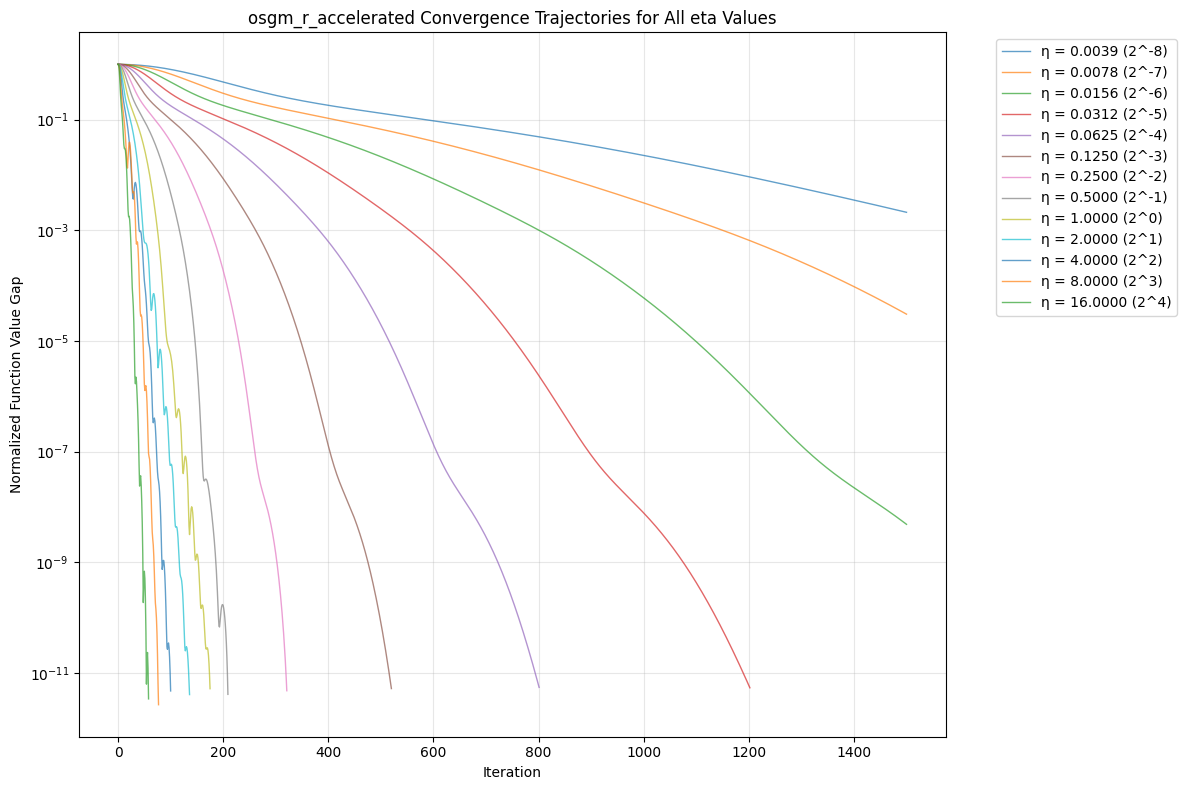

In [262]:
eta_range_osgm_r_acc = [[2.0 ** exp for exp in range(-12, -6)], [2.0 ** exp for exp in range(-12, -4)], [2.0 ** exp for exp in range(-8, -3)], [2.0 ** exp for exp in range(-8, 5)]]
for i in range(len(sigmas)):
  A, b, sigma = datasets[i]
  print(f"Sigma: {sigma}")
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  histories_osgm_r_acc = plot_eta_convergence_analysis(
      'osgm_r_accelerated', eta_range_osgm_r_acc[i], f, grad_f, x_init, K, f_star, P_i, A, b
  )

In [263]:
def plot_AOR_HB_eta_analysis(eta_P_range, eta_beta_range, f, grad_f, x_init, num_iterations, L, mu, f_star,
                           convergence_iter_point=1400):
    print(f"Testing AOR_HB with {len(eta_P_range)}×{len(eta_beta_range)} parameter combinations")

    results = run_AOR_HB_methods(eta_P_range, eta_beta_range, f, grad_f, x_init, num_iterations, L, mu, f_star)

    plt.figure(figsize=(12, 8))

    convergence_values = []

    for (gap_history, eta_P, eta_beta) in results:
        if gap_history:
            iter_to_use = min(convergence_iter_point, len(gap_history) - 1)
            convergence_value = gap_history[iter_to_use]
            convergence_values.append((eta_P, eta_beta, convergence_value))

            plt.semilogy(eta_P, eta_beta, 'bo', markersize=8, alpha=0.7)
            plt.text(eta_P, eta_beta, f'{convergence_value:.1e}', fontsize=8, ha='center', va='bottom')

    plt.xlabel('eta_P')
    plt.ylabel('eta_beta')
    plt.title(f'AOR_HB Convergence after {convergence_iter_point} iterations')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.show()

    plt.figure(figsize=(12, 8))

    for (gap_history, eta_P, eta_beta) in results:
        if gap_history:
            exponent_P = int(np.log2(eta_P)) if eta_P > 0 else -float('inf')
            exponent_beta = int(np.log2(eta_beta)) if eta_beta > 0 else -float('inf')
            plt.plot(gap_history, label=f'η_P=2^{exponent_P}, η_β=2^{exponent_beta}',
                    alpha=0.7, linewidth=1)

    plt.xlabel('Iteration')
    plt.ylabel('Normalized Function Value Gap')
    plt.title('AOR_HB Convergence Trajectories for All Parameter Combinations')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results

def find_best_AOR_HB_params(results):

    best_value = float('inf')
    best_params = None
    best_history = None

    for (gap_history, eta_P, eta_beta) in results:
        if gap_history and len(gap_history) > 0:
            current_value = min(gap_history)
            if current_value < best_value:
                best_value = current_value
                best_params = (eta_P, eta_beta)
                best_history = gap_history

    return best_params, best_history, best_value

Sigma: 0.0001
Testing AOR_HB with 6×8 parameter combinations


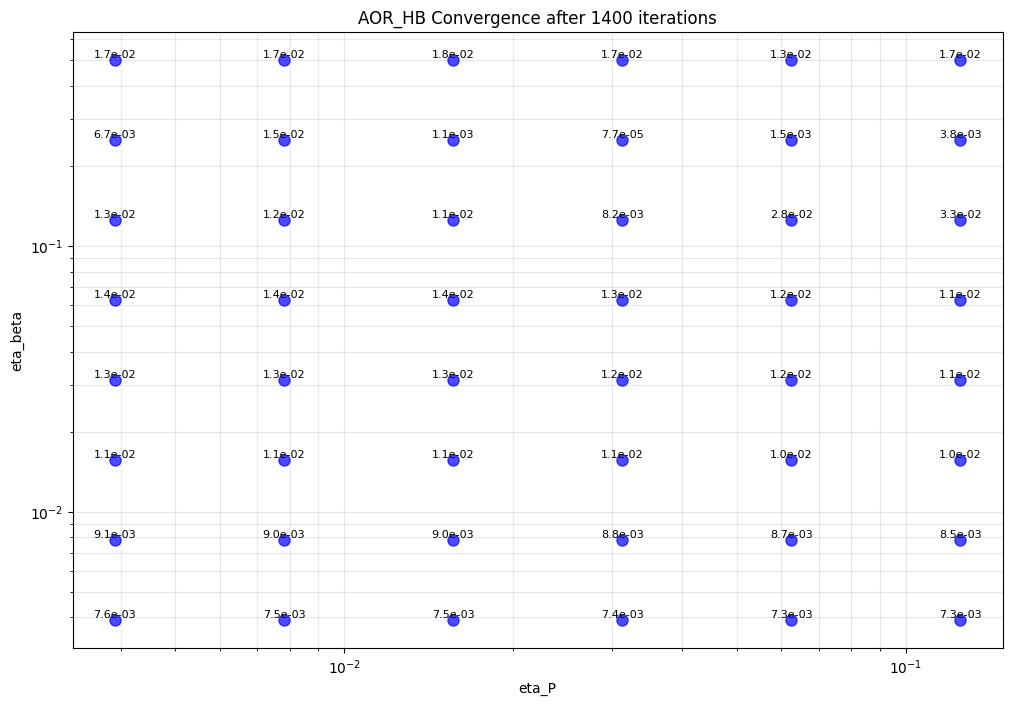

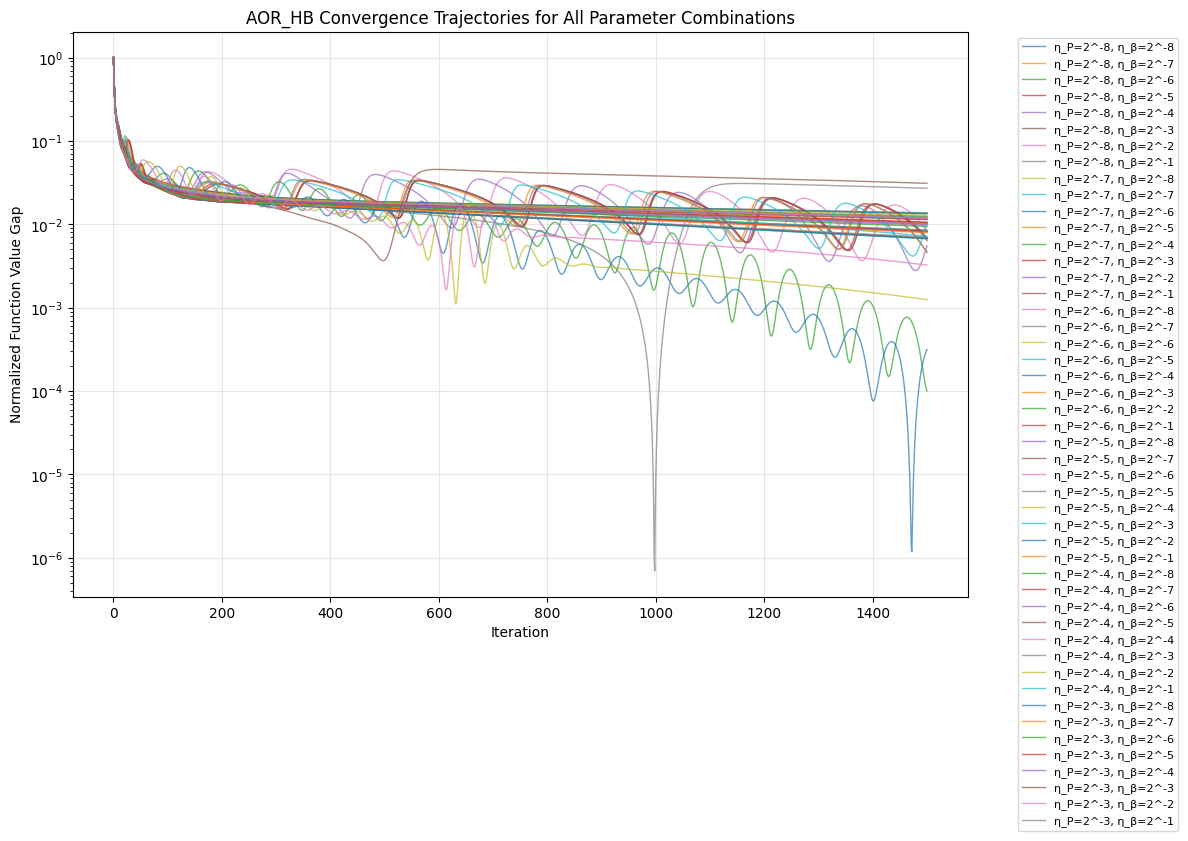

Best AOR_HB parameters: eta_P=0.062500, eta_beta=0.125000
Best value: 6.98e-07
Sigma: 0.001
Testing AOR_HB with 6×8 parameter combinations


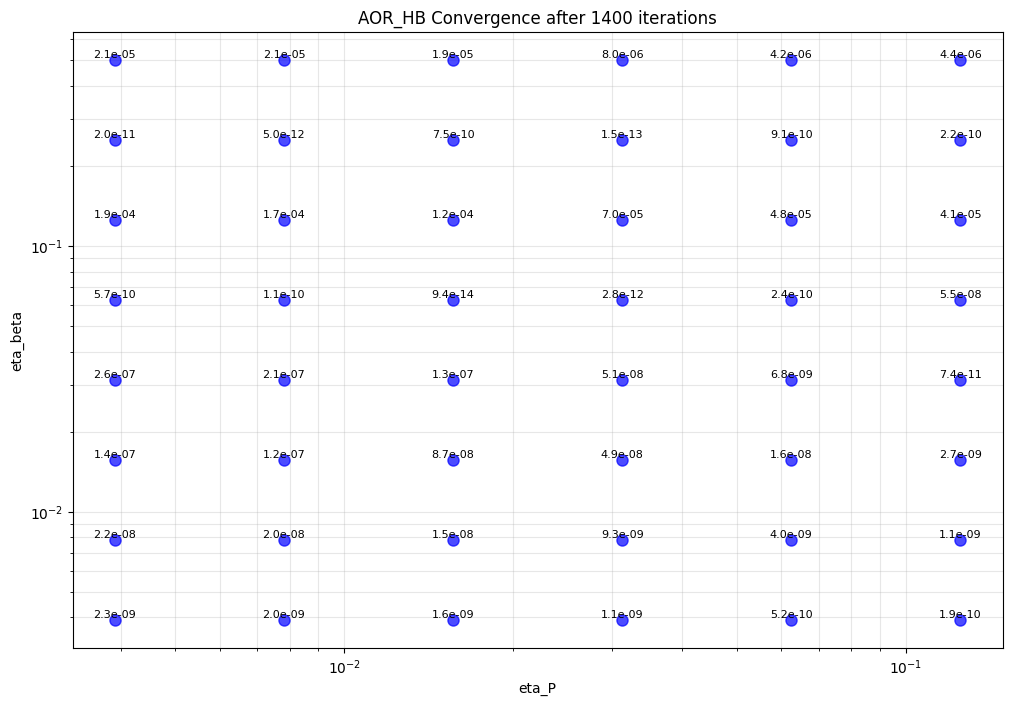

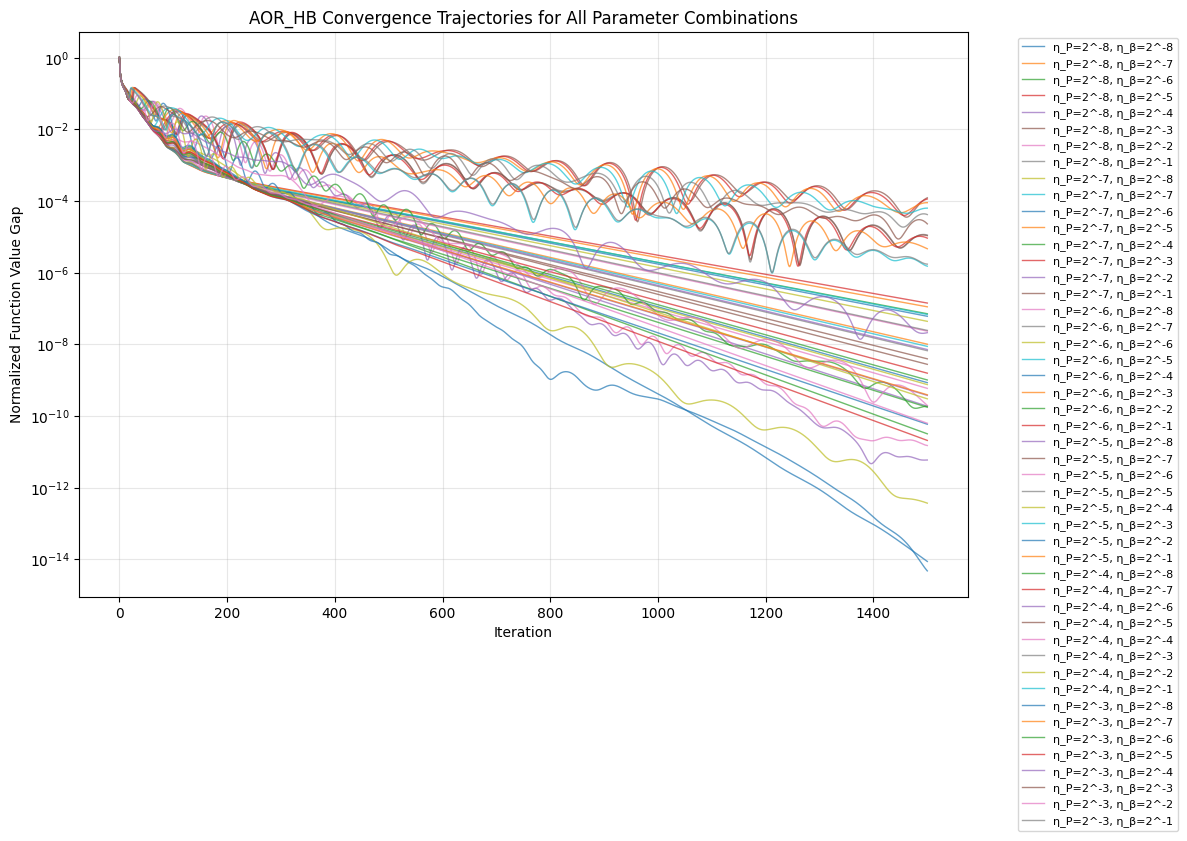

Best AOR_HB parameters: eta_P=0.031250, eta_beta=0.250000
Best value: 4.74e-15
Sigma: 0.01
Testing AOR_HB with 6×8 parameter combinations
AOR_HB converged at iteration 1260
AOR_HB converged at iteration 1005
AOR_HB converged at iteration 797
AOR_HB converged at iteration 564
AOR_HB converged at iteration 1083
AOR_HB converged at iteration 1133
AOR_HB converged at iteration 1122
AOR_HB converged at iteration 1260
AOR_HB converged at iteration 1005
AOR_HB converged at iteration 800
AOR_HB converged at iteration 564
AOR_HB converged at iteration 1066
AOR_HB converged at iteration 1106
AOR_HB converged at iteration 1123
AOR_HB converged at iteration 1261
AOR_HB converged at iteration 1006
AOR_HB converged at iteration 803
AOR_HB converged at iteration 566
AOR_HB converged at iteration 1033
AOR_HB converged at iteration 1056
AOR_HB converged at iteration 1122
AOR_HB converged at iteration 1261
AOR_HB converged at iteration 1008
AOR_HB converged at iteration 806
AOR_HB converged at iteration

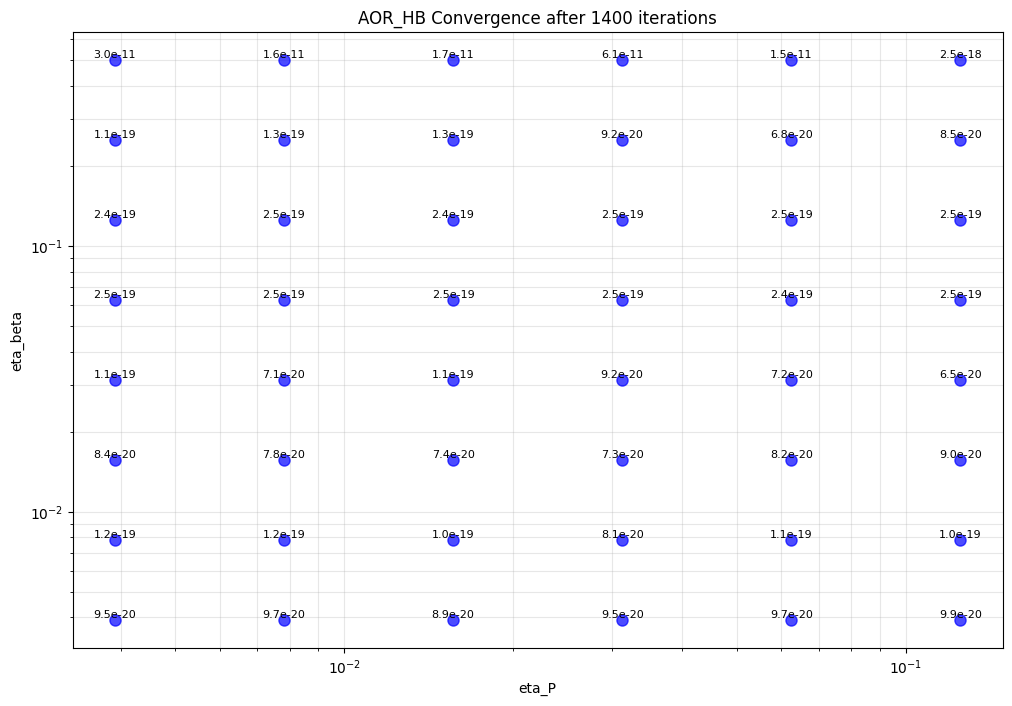

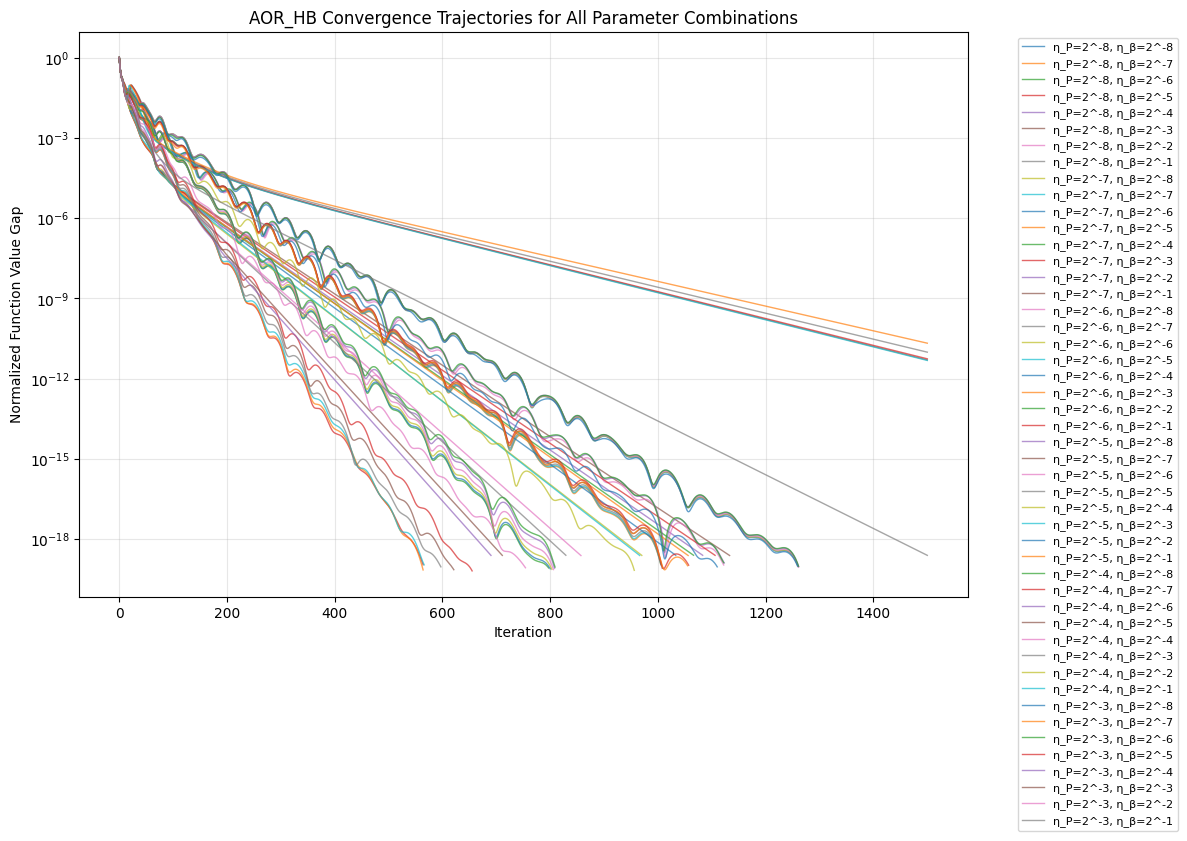

Best AOR_HB parameters: eta_P=0.125000, eta_beta=0.031250
Best value: 6.49e-20
Sigma: 0.1
Testing AOR_HB with 5×8 parameter combinations
AOR_HB converged at iteration 919
AOR_HB converged at iteration 742
AOR_HB converged at iteration 613
AOR_HB converged at iteration 421
AOR_HB converged at iteration 374
AOR_HB converged at iteration 1102
AOR_HB converged at iteration 1125
AOR_HB converged at iteration 690
AOR_HB converged at iteration 917
AOR_HB converged at iteration 741
AOR_HB converged at iteration 593
AOR_HB converged at iteration 419
AOR_HB converged at iteration 329
AOR_HB converged at iteration 798
AOR_HB converged at iteration 297
AOR_HB converged at iteration 935
AOR_HB converged at iteration 914
AOR_HB converged at iteration 740
AOR_HB converged at iteration 590
AOR_HB converged at iteration 417
AOR_HB converged at iteration 345
AOR_HB converged at iteration 356
AOR_HB converged at iteration 471
AOR_HB converged at iteration 570
AOR_HB converged at iteration 891
AOR_HB conv

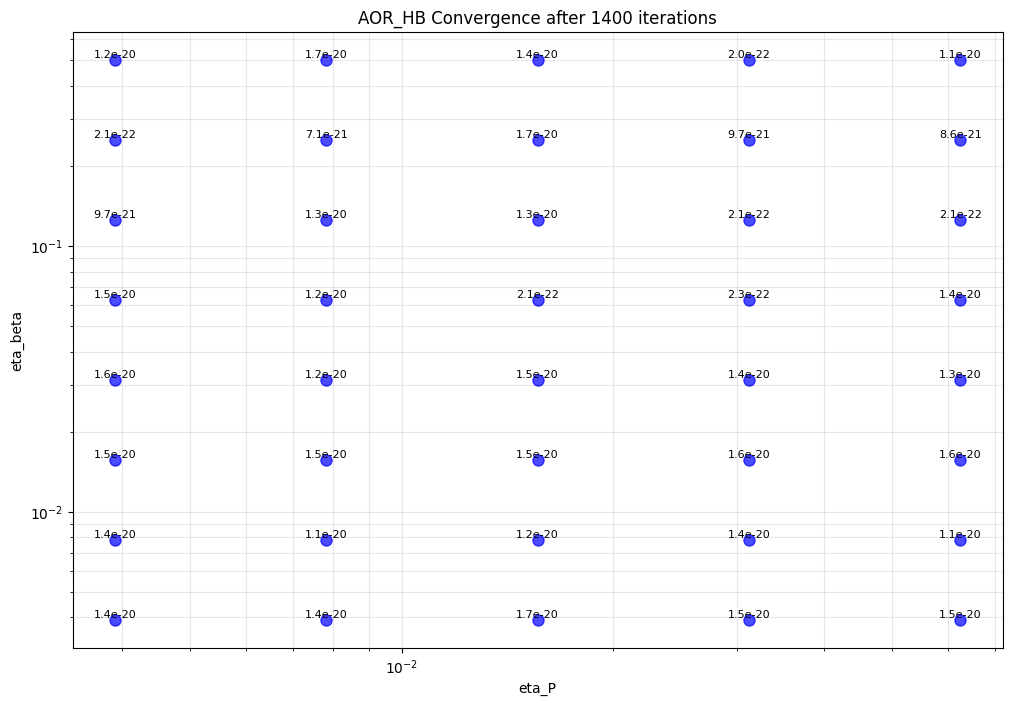

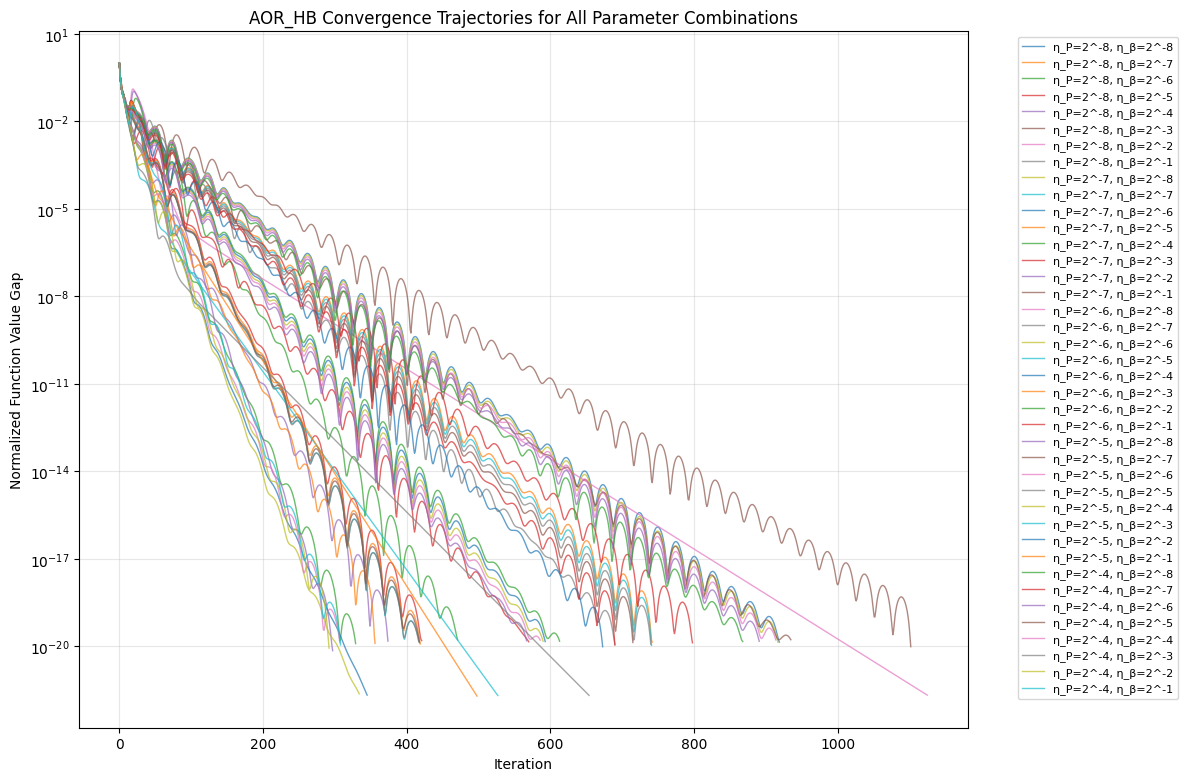

Best AOR_HB parameters: eta_P=0.031250, eta_beta=0.500000
Best value: 1.96e-22


In [264]:
eta_P_range_AOR_HB = [[2.0 ** exp for exp in range(-8, -2)],
                      [2.0 ** exp for exp in range(-8, -2)],
                      [2.0 ** exp for exp in range(-8, -2)],
                      [2.0 ** exp for exp in range(-8, -3)]]

eta_beta_range_AOR_HB = [[2.0 ** exp for exp in range(-8, 0)],
                         [2.0 ** exp for exp in range(-8, 0)],
                         [2.0 ** exp for exp in range(-8, 0)],
                         [2.0 ** exp for exp in range(-8, 0)]]

for i in range(len(sigmas)):
    A, b, sigma = datasets[i]
    print(f"Sigma: {sigma}")
    f = lambda x: least_squares_function(x, A, b)
    grad_f = grad(f)

    histories_AOR_HB = plot_AOR_HB_eta_analysis(
        eta_P_range_AOR_HB[i], eta_beta_range_AOR_HB[i],
        f, grad_f, x_init, K, L, mu, f_star
    )

    best_params, best_history, best_value = find_best_AOR_HB_params(histories_AOR_HB)
    if best_params:
        eta_P_best, eta_beta_best = best_params
        print(f"Best AOR_HB parameters: eta_P={eta_P_best:.6f}, eta_beta={eta_beta_best:.6f}")
        print(f"Best value: {best_value:.2e}")

2436824.359553117
816892.7421944271
OSGM-H converged at iteration 2249 with gradient norm 9.98e-11
8803.41578776831


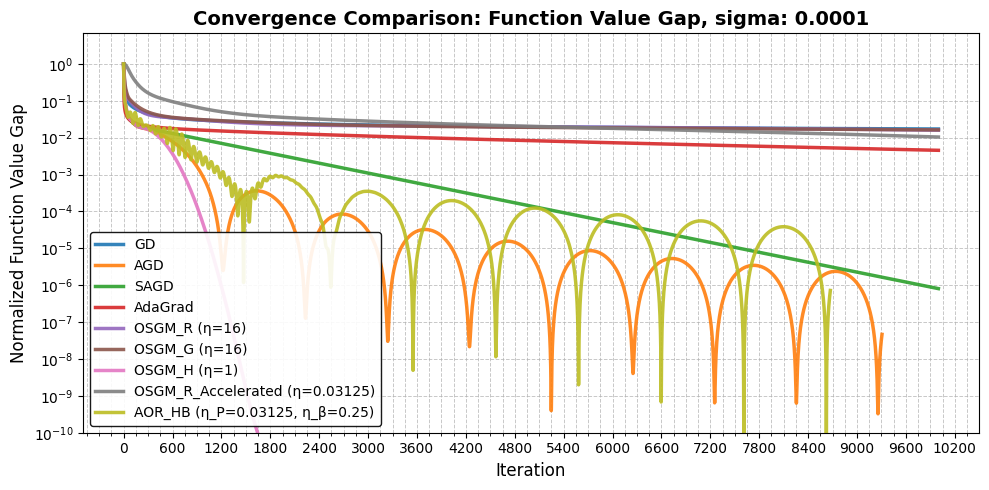

SAGD converged at iteration 2119 with gradient norm 1.00e-10
AdaGrad converged at iteration 8583
OSGM-R converged at iteration 9517 with gradient norm 2.34e-07 and function gap 9.99e-11
878.7073672753224
9920.97395515236
OSGM-H converged at iteration 862 with gradient norm 9.80e-11
416.32871756732345
AOR_HB converged at iteration 2062


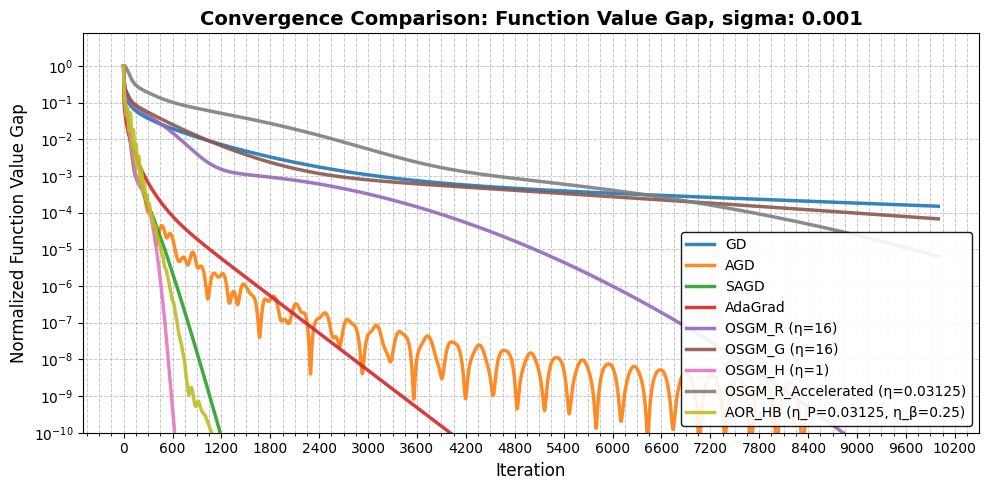

AGD converged at iteration 8630 with gradient norm 5.26e-11
SAGD converged at iteration 1535 with gradient norm 9.93e-11
AdaGrad converged at iteration 666
OSGM-R converged at iteration 999 with gradient norm 8.03e-07 and function gap 9.70e-11
104.98441272531458
OSGM-G converged at iteration 7070 with gradient norm 1.00e-10
635.6047402006449
OSGM-H converged at iteration 349 with gradient norm 9.50e-11
21.484080726464217
OSGM_R_Accelerated converged at iteration 1812 with grad_norm=1.09e-06 and f_gap=8.80e-11
AOR_HB converged at iteration 655


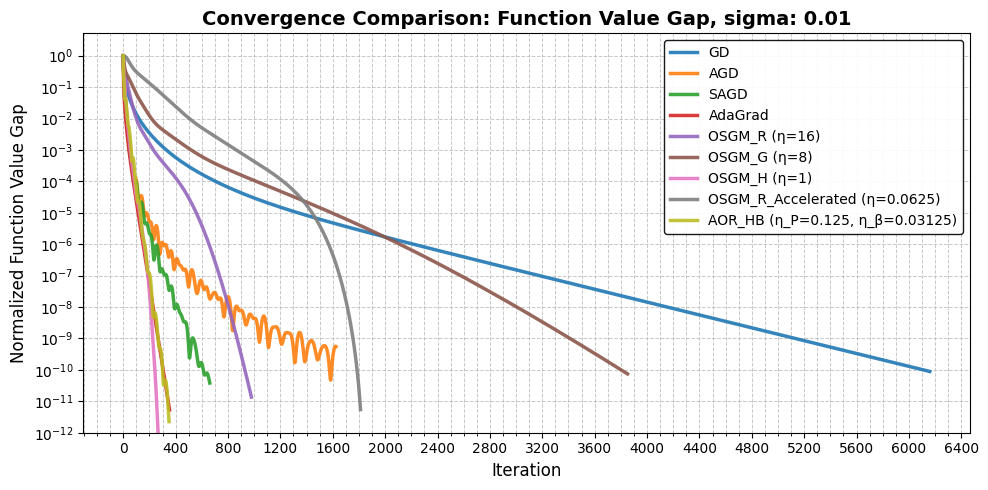

GD converged at iteration 1352 with gradient norm 9.98e-11
AGD converged at iteration 1531 with gradient norm 9.92e-11
SAGD converged at iteration 973 with gradient norm 8.75e-11
AdaGrad converged at iteration 402
OSGM-R converged at iteration 142 with gradient norm 2.48e-06 and function gap 7.87e-11
15.762890801626273
inf
OSGM-H converged at iteration 169 with gradient norm 8.89e-11
18.53617386496169
OSGM_R_Accelerated converged at iteration 39 with grad_norm=5.82e-06 and f_gap=6.08e-11
AOR_HB converged at iteration 498


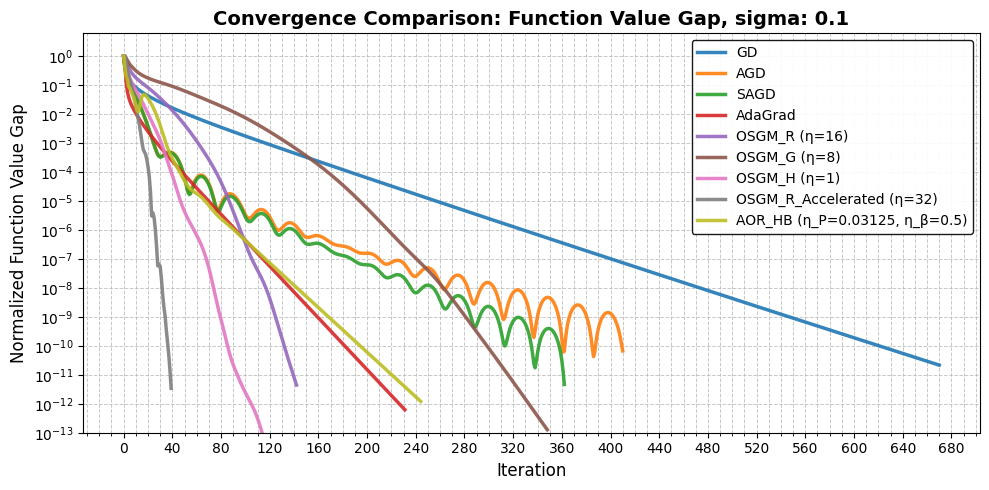

In [265]:
K = 10000 # проверки кончились, можно вернуть количество итераций
min_display_value_candidates = [1e-10, 1e-10, 1e-12, 1e-13]
eta_candidates_osgm_r_list = [[2**4], [2**4], [2**4], [2**4]] # also parameters one can change to check different etas, I've chosen the best ones
eta_candidates_osgm_g_list = [[2**4], [2**4], [2**3], [2**3]]
eta_candidates_osgm_h_list = [[2**0], [2**0], [2**0], [2**0]]
eta_candidates_osgm_r_accelerated_list = [[2**-5], [2**-5], [2**-4], [2**5]]
eta_P_candidates_AOR_HB_list = [[2**-5], [2**-5], [2**-3], [2**-5]]
eta_beta_candidates_AOR_HB_list = [[2**-2], [2**-2], [2**-5], [2**-1]]
histories_with_info = []
for i in range(len(sigmas)):
  A, b, sigma = datasets[i]
  min_display_value = min_display_value_candidates[i]
  f = lambda x: least_squares_function(x, A, b)
  grad_f = grad(f)
  eta_candidates_osgm_r = eta_candidates_osgm_r_list[i]
  eta_candidates_osgm_g = eta_candidates_osgm_g_list[i]
  eta_candidates_osgm_h = eta_candidates_osgm_h_list[i]
  eta_candidates_osgm_r_accelerated = eta_candidates_osgm_r_accelerated_list[i]
  eta_P_candidates_AOR_HB = eta_P_candidates_AOR_HB_list[i]
  eta_beta_candidates_AOR_HB = eta_beta_candidates_AOR_HB_list[i]

  gap_history_gd = run_basic_optimizer(gd, f, grad_f, x_init, K, f_star, L=L)
  gap_history_agd = run_basic_optimizer(agd, f, grad_f, x_init, K, f_star, L=L)
  gap_history_sagd = run_basic_optimizer(sagd, f, grad_f, x_init, K, f_star, L=L, mu=mu)
  gap_history_adagrad = run_basic_optimizer(adagrad, f, grad_f, x_init, K, f_star)

  gap_history_osgm_r_all = run_osgm_methods(eta_candidates_osgm_r, f, grad_f, P_i, x_init, K, f_star, 'osgm_r')
  gap_history_osgm_g_all = run_osgm_methods(eta_candidates_osgm_g, f, grad_f, P_i, x_init, K, f_star, 'osgm_g', A=A)
  gap_history_osgm_h_all = run_osgm_methods(eta_candidates_osgm_h, f, grad_f, P_i, x_init, K, f_star, 'osgm_h')
  gap_history_osgm_r_all_accelerated = run_osgm_methods(eta_candidates_osgm_r_accelerated, f, grad_f, P_i, x_init, K, f_star,'osgm_r_accelerated', A, b)

  gap_history_AOR_HB = run_AOR_HB_methods(eta_P_candidates_AOR_HB, eta_beta_candidates_AOR_HB,f, grad_f, x_init, K, L, mu, f_star)

  histories_with_info = [
      (gap_history_gd, 'GD', None),
      (gap_history_agd, 'AGD', None),
      (gap_history_sagd, 'SAGD', None),
      (gap_history_adagrad, 'AdaGrad', None),
  ]

  for idx, eta in enumerate(eta_candidates_osgm_r):
      if idx < len(gap_history_osgm_r_all):
          histories_with_info.append((gap_history_osgm_r_all[idx], 'OSGM_R', eta))

  for idx, eta in enumerate(eta_candidates_osgm_g):
      if idx < len(gap_history_osgm_g_all):
          histories_with_info.append((gap_history_osgm_g_all[idx], 'OSGM_G', eta))

  for idx, eta in enumerate(eta_candidates_osgm_h):
      if idx < len(gap_history_osgm_h_all):
          histories_with_info.append((gap_history_osgm_h_all[idx], 'OSGM_H', eta))

  for idx, eta in enumerate(eta_candidates_osgm_r_accelerated):
      if idx < len(gap_history_osgm_r_all_accelerated):
          histories_with_info.append((gap_history_osgm_r_all_accelerated[idx], 'OSGM_R_Accelerated', eta))

  for gap_history, eta_P, eta_beta in gap_history_AOR_HB:
      histories_with_info.append((gap_history, f'AOR_HB (η_P={eta_P}, η_β={eta_beta})', None))

  plot_convergence_smart(histories_with_info, sigma, max_display_iter=10000, tol=1e-10, min_display_value=min_display_value)